In [1]:
import pandas as pd
import numpy as np
import glob as glob
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, DrawingArea, OffsetImage, AnnotationBbox
from scipy.signal import butter, lfilter
from scipy.signal import butter, filtfilt
import os
from pathlib import Path
from scipy.stats import ttest_ind

Import Files

Import all files from specified folder and assign the compounds applied in each. Folder should only contain files from a single plate and single injection, the datatable and trace for each.

In [6]:
path = r'/Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/acr21_lgc4/BAPTA' # use your path
data_tables = glob.glob(path + "/*Datatable*.xlsx") # use your extension
traces = glob.glob(path + "/*Traces*.dat") # use your extension

li = []
li2 = []

for filename in data_tables:
    base_filename = os.path.splitext(os.path.basename(filename))[0]  # e.g., 'TR_lgc-4.acr-21_01.05.25_Export_Datatable'
    short_filename = base_filename.rpartition('_')[0]  # everything before the last '_'
    df = pd.read_excel(filename, index_col=None, header=0)
    df['filename'] = short_filename
    df['unique_trace_ID'] = short_filename + '_' + df['ID'].astype(str)
    li.append(df)

for filename in traces:
    df_trace = pd.read_csv(filename, index_col=None, header=0, sep='\t')  # Read .dat or .csv with tab separator
    df_trace_transposed = df_trace.transpose()

    df_trace_transposed['recording_info'] = df_trace_transposed.index

    # Get filename without extension
    base_filename = os.path.splitext(os.path.basename(filename))[0]
    # Get part before the last underscore
    short_filename = base_filename.rpartition('_')[0]

    df_trace_transposed['filename'] = short_filename
    df_trace_transposed['ID'] = df_trace_transposed['recording_info'].str.split('-').str[-1]
    df_trace_transposed['unique_trace_ID'] = short_filename + '_' + df_trace_transposed['ID']
    df_trace_transposed['type'] = df_trace_transposed['recording_info'].str[0:5]

    # Drop rows where 'type' contains 'Time('
    df_filtered = df_trace_transposed[df_trace_transposed['type'] != 'Time(']
    df_filtered.reset_index(drop=True, inplace=True)
    df_filtered.columns.name = 'Time (ms)'

    li2.append(df_filtered)

data_table = pd.concat(li, axis=0, ignore_index=True)
data_traces = pd.concat(li2, axis=0, ignore_index=True)
data_traces.columns.name = 'Time (ms)'

data_table.head(5)

,IV Prot.,IVCurveID,Well,BAPTA,ID,Series,ROI,Minimum,Pos Min,Maximum,...,unit 1,Comp. 2,conc. 2,unit 2,Comp. 3,conc. 3,unit 3,Extremum,filename,unique_trace_ID
0,NaN,NaN,A1,0,0,0,0,-785,18902,3,...,µM,empty,0,mM,empty,0,mM,-785,TR_lgc-4.acr-21_01.05.25_Export,TR_lgc-4.acr-21_01.05.25_Export_0
1,NaN,NaN,A2,0,1,0,0,-1649,16296,1,...,µM,empty,0,mM,empty,0,mM,-1649,TR_lgc-4.acr-21_01.05.25_Export,TR_lgc-4.acr-21_01.05.25_Export_1
2,NaN,NaN,A3,0,2,0,0,-2232,14816,0,...,µM,empty,0,mM,empty,0,mM,-2232,TR_lgc-4.acr-21_01.05.25_Export,TR_lgc-4.acr-21_01.05.25_Export_2
3,NaN,NaN,A4,0,3,0,0,-1669,16466,5,...,µM,empty,0,mM,empty,0,mM,-1669,TR_lgc-4.acr-21_01.05.25_Export,TR_lgc-4.acr-21_01.05.25_Export_3
4,NaN,NaN,A5,0,4,0,0,-3878,15760,3,...,µM,empty,0,mM,empty,0,mM,-3878,TR_lgc-4.acr-21_01.05.25_Export,TR_lgc-4.acr-21_01.05.25_Export_4


In [46]:
# Directory to save PDF files
path2 = Path(path)  # use your path
output_folder = path2 / 'output_plots'
# Create the output folder if it doesn't exist
output_folder.mkdir(parents=True, exist_ok=True)

In [7]:
count_unique_ids = data_table['unique_trace_ID'].nunique()
print(f"Number of unique trace IDs: {count_unique_ids}")
unique_ids_list = data_table['unique_trace_ID'].unique().tolist()

Number of unique trace IDs: 56


In [8]:
duplicate_columns = data_traces.columns[data_traces.columns.duplicated()]

if len(duplicate_columns) == 0:
    print("No duplicated column names.")
else:
    print("Duplicated column names:", duplicate_columns.tolist())

No duplicated column names.


In [9]:
# Column names based on the standard column titles from Robocyte2+ software export
selected_columns = ['Well', 'Buffer', 'Comp. 1', 'conc. 1', 'unit 1', 'Minimum', 'Baseline Average', 'ID', 'BAPTA', 'unique_trace_ID']

# Select columns and create a copy to avoid chained assignment warning
data_table_info = data_table[selected_columns].copy()

# Transform units to µM scale
conditions = [
    (data_table_info['unit 1'] == 'mM'),
    (data_table_info['unit 1'] == 'µM'),
    (data_table_info['unit 1'] == 'nM')
]

choices = ['1000', '1', '0.001']

# Use .loc to set values for the 'factor' column
data_table_info.loc[:, 'factor'] = np.select(conditions, choices, default='0').astype(float)

# Use .loc to set values for the 'Agonist_Concentration_µM' column
data_table_info.loc[:, 'Agonist_Concentration_µM'] = data_table_info['conc. 1'] * data_table_info['factor']

# Select final columns
final_columns = ['Well', 'Buffer', 'Comp. 1', 'Minimum', 'Agonist_Concentration_µM', 'ID', 'BAPTA', 'unique_trace_ID']
data_table_info = data_table_info[final_columns]

# Reset index
data_table_info.reset_index(drop=True, inplace=True)

data_table_info.head()

,Well,Buffer,Comp. 1,Minimum,Agonist_Concentration_µM,ID,BAPTA,unique_trace_ID
0,A1,ND96 + ascorbic acid,Dopamine + ascorbic acid,-785,30.0,0,0,TR_lgc-4.acr-21_01.05.25_Export_0
1,A2,ND96 + ascorbic acid,Dopamine + ascorbic acid,-1649,30.0,1,0,TR_lgc-4.acr-21_01.05.25_Export_1
2,A3,ND96 + ascorbic acid,Dopamine + ascorbic acid,-2232,30.0,2,0,TR_lgc-4.acr-21_01.05.25_Export_2
3,A4,ND96 + ascorbic acid,Dopamine + ascorbic acid,-1669,30.0,3,0,TR_lgc-4.acr-21_01.05.25_Export_3
4,A5,ND96 + ascorbic acid,Dopamine + ascorbic acid,-3878,30.0,4,0,TR_lgc-4.acr-21_01.05.25_Export_4


In [10]:
nan_count = data_traces['unique_trace_ID'].isna().sum()
print("Number of NaN values in 'ID' column:", nan_count)

Number of NaN values in 'ID' column: 0


In [11]:
count_unique_ids = data_table_info['unique_trace_ID'].nunique()
print(f"Number of unique trace IDs: {count_unique_ids}")
unique_ids_list = data_table_info['unique_trace_ID'].unique().tolist()

Number of unique trace IDs: 56


In [12]:
# Merging on the 'unique_trace_ID' column
merged_data = pd.merge(data_table_info, data_traces, on='unique_trace_ID')
# Replace BAPTA values: 1 -> 'BAPTA', 0 -> 'ctrl'
merged_data['BAPTA_label'] = merged_data['BAPTA'].apply(lambda x: 'BAPTA' if x == 1 else 'ctrl')
# Create new column with the formatted string
merged_data['unique_trace_ID'] = merged_data['BAPTA_label'] + '_' + merged_data['Well'] + '_' + merged_data['unique_trace_ID']
# Display the result
merged_data.head()

,Well,Buffer,Comp. 1,Minimum,Agonist_Concentration_µM,ID_x,BAPTA,unique_trace_ID,0,1,...,38898,38899,38900,38901,38902,recording_info,filename,ID_y,type,BAPTA_label
0,A1,ND96 + ascorbic acid,Dopamine + ascorbic acid,-785,30.0,0,0,ctrl_A1_TR_lgc-4.acr-21_01.05.25_Export_0,-0.6,-1.0,...,NaN,NaN,NaN,NaN,NaN,J(nA)_RecordingID-0,TR_lgc-4.acr-21_01.05.25_Export,0,J(nA),ctrl
1,A2,ND96 + ascorbic acid,Dopamine + ascorbic acid,-1649,30.0,1,0,ctrl_A2_TR_lgc-4.acr-21_01.05.25_Export_1,6.2,6.3,...,NaN,NaN,NaN,NaN,NaN,J(nA)_RecordingID-1,TR_lgc-4.acr-21_01.05.25_Export,1,J(nA),ctrl
2,A3,ND96 + ascorbic acid,Dopamine + ascorbic acid,-2232,30.0,2,0,ctrl_A3_TR_lgc-4.acr-21_01.05.25_Export_2,5.0,4.3,...,NaN,NaN,NaN,NaN,NaN,J(nA)_RecordingID-2,TR_lgc-4.acr-21_01.05.25_Export,2,J(nA),ctrl
3,A4,ND96 + ascorbic acid,Dopamine + ascorbic acid,-1669,30.0,3,0,ctrl_A4_TR_lgc-4.acr-21_01.05.25_Export_3,6.7,7.6,...,NaN,NaN,NaN,NaN,NaN,J(nA)_RecordingID-3,TR_lgc-4.acr-21_01.05.25_Export,3,J(nA),ctrl
4,A5,ND96 + ascorbic acid,Dopamine + ascorbic acid,-3878,30.0,4,0,ctrl_A5_TR_lgc-4.acr-21_01.05.25_Export_4,7.2,6.7,...,NaN,NaN,NaN,NaN,NaN,J(nA)_RecordingID-4,TR_lgc-4.acr-21_01.05.25_Export,4,J(nA),ctrl


In [13]:
count_unique_ids = merged_data['unique_trace_ID'].nunique()
print(f"Number of unique trace IDs: {count_unique_ids}")
unique_ids_list = merged_data['unique_trace_ID'].unique().tolist()
unique_ids_list

Number of unique trace IDs: 56


['ctrl_A1_TR_lgc-4.acr-21_01.05.25_Export_0',
 'ctrl_A2_TR_lgc-4.acr-21_01.05.25_Export_1',
 'ctrl_A3_TR_lgc-4.acr-21_01.05.25_Export_2',
 'ctrl_A4_TR_lgc-4.acr-21_01.05.25_Export_3',
 'ctrl_A5_TR_lgc-4.acr-21_01.05.25_Export_4',
 'ctrl_A10_TR_lgc-4.acr-21_01.05.25_Export_5',
 'ctrl_A12_TR_lgc-4.acr-21_01.05.25_Export_6',
 'ctrl_B1_TR_lgc-4.acr-21_01.05.25_Export_7',
 'ctrl_B3_TR_lgc-4.acr-21_01.05.25_Export_8',
 'ctrl_B4_TR_lgc-4.acr-21_01.05.25_Export_9',
 'ctrl_A9_TR_lgc-4.acr-21_01.05.25_Export_10',
 'BAPTA_A1_TR_lgc-4.acr-21_01.05.25_Export_11',
 'BAPTA_A2_TR_lgc-4.acr-21_01.05.25_Export_12',
 'BAPTA_A3_TR_lgc-4.acr-21_01.05.25_Export_13',
 'BAPTA_A4_TR_lgc-4.acr-21_01.05.25_Export_14',
 'BAPTA_A5_TR_lgc-4.acr-21_01.05.25_Export_15',
 'ctrl_A9_TR_lgc-4.acr-21_01.05.25_Export_16',
 'ctrl_A10_TR_lgc-4.acr-21_01.05.25_Export_17',
 'ctrl_A12_TR_lgc-4.acr-21_01.05.25_Export_18',
 'ctrl_B1_TR_lgc-4.acr-21_01.05.25_Export_19',
 'ctrl_B3_TR_lgc-4.acr-21_01.05.25_Export_20',
 'ctrl_B4_TR_l

In [14]:
merged_data_T = merged_data.T
# Set 'new_col_header' as the new header
new_col_header_row = merged_data_T.iloc[7]
merged_data_T.columns = new_col_header_row
# Drop the first 8 rows and set the last row as the header
merged_data_T = merged_data_T.iloc[8:]
# Drop the last 3 rows
merged_data_T = merged_data_T.iloc[:-3]
# Reset the index if needed
merged_data_T.reset_index(drop=True, inplace=True)
merged_data_T.columns.name = 'Time (ms)'
merged_data_T.head(100)

Time (ms),ctrl_A1_TR_lgc-4.acr-21_01.05.25_Export_0,ctrl_A2_TR_lgc-4.acr-21_01.05.25_Export_1,ctrl_A3_TR_lgc-4.acr-21_01.05.25_Export_2,ctrl_A4_TR_lgc-4.acr-21_01.05.25_Export_3,ctrl_A5_TR_lgc-4.acr-21_01.05.25_Export_4,ctrl_A10_TR_lgc-4.acr-21_01.05.25_Export_5,ctrl_A12_TR_lgc-4.acr-21_01.05.25_Export_6,ctrl_B1_TR_lgc-4.acr-21_01.05.25_Export_7,ctrl_B3_TR_lgc-4.acr-21_01.05.25_Export_8,ctrl_B4_TR_lgc-4.acr-21_01.05.25_Export_9,...,BAPTA_A10_TR_BAPTA_acr21+lgc4_29.04.25_Export_39,BAPTA_B1_TR_BAPTA_acr21+lgc4_29.04.25_Export_40,BAPTA_B2_TR_BAPTA_acr21+lgc4_29.04.25_Export_41,BAPTA_B3_TR_BAPTA_acr21+lgc4_29.04.25_Export_42,BAPTA_B4_TR_BAPTA_acr21+lgc4_29.04.25_Export_43,BAPTA_B5_TR_BAPTA_acr21+lgc4_29.04.25_Export_44,BAPTA_C1_TR_BAPTA_acr21+lgc4_29.04.25_Export_45,BAPTA_C3_TR_BAPTA_acr21+lgc4_29.04.25_Export_46,BAPTA_C4_TR_BAPTA_acr21+lgc4_29.04.25_Export_47,BAPTA_C7_TR_BAPTA_acr21+lgc4_29.04.25_Export_48
0,-0.6,6.2,5.0,6.7,7.2,0.6,-1.8,3.6,-2.6,-1.6,...,21.8,538.1,14.7,7.1,12.0,4.4,-9.1,9.8,17.4,385.9
1,-1.0,6.3,4.3,7.6,6.7,1.2,-2.7,3.4,-3.6,-1.0,...,20.4,538.0,14.9,6.5,11.4,8.3,-10.2,9.0,18.6,381.9
2,-0.7,7.2,3.3,7.9,6.9,1.8,-1.9,2.2,-3.5,-1.9,...,20.0,537.8,15.2,4.1,10.2,9.3,-9.0,9.8,18.8,377.1
3,-0.4,6.4,3.2,8.1,6.8,0.5,-0.5,2.2,-4.4,-2.6,...,18.4,538.0,15.4,4.7,8.9,8.7,-8.4,9.4,16.7,369.1
4,-1.0,7.1,3.2,7.7,8.4,0.6,-0.6,2.8,-2.8,-2.2,...,17.6,538.4,15.1,5.8,8.7,10.1,-6.1,10.4,14.7,361.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-3.7,5.3,2.4,1.3,3.5,-0.7,-3.2,1.8,-4.2,-0.2,...,21.7,535.8,16.7,5.0,13.0,9.9,-9.5,8.7,19.5,401.6
96,-4.0,6.7,2.2,0.2,3.9,-0.6,-1.8,1.2,-4.0,-0.7,...,21.6,537.0,15.7,5.3,10.8,9.6,-8.7,9.0,19.0,400.5
97,-4.2,7.0,3.1,0.4,4.4,-0.2,-3.0,2.3,-3.8,-0.7,...,20.0,537.6,15.0,5.5,9.8,9.2,-9.4,8.8,18.2,398.4
98,-3.2,6.6,3.6,2.2,6.6,-0.3,-2.7,1.6,-2.4,-1.2,...,20.8,538.7,13.9,7.0,9.3,7.8,-8.6,8.9,17.1,393.0


In [15]:
#define filter
cutoff = 50 #Hz above which to remove
Fs = 5000 #Hz sample
Wn = cutoff / (Fs / 2.0)
b, a = butter(N=4, Wn=Wn, btype='low', analog=False, output='ba')
# Apply the filter to each column
merged_data_T = merged_data_T.apply(pd.to_numeric, errors='coerce')
merged_data_filtered = merged_data_T.apply(lambda col: lfilter(b, a, col))
merged_data_filtered.head()

Time (ms),ctrl_A1_TR_lgc-4.acr-21_01.05.25_Export_0,ctrl_A2_TR_lgc-4.acr-21_01.05.25_Export_1,ctrl_A3_TR_lgc-4.acr-21_01.05.25_Export_2,ctrl_A4_TR_lgc-4.acr-21_01.05.25_Export_3,ctrl_A5_TR_lgc-4.acr-21_01.05.25_Export_4,ctrl_A10_TR_lgc-4.acr-21_01.05.25_Export_5,ctrl_A12_TR_lgc-4.acr-21_01.05.25_Export_6,ctrl_B1_TR_lgc-4.acr-21_01.05.25_Export_7,ctrl_B3_TR_lgc-4.acr-21_01.05.25_Export_8,ctrl_B4_TR_lgc-4.acr-21_01.05.25_Export_9,...,BAPTA_A10_TR_BAPTA_acr21+lgc4_29.04.25_Export_39,BAPTA_B1_TR_BAPTA_acr21+lgc4_29.04.25_Export_40,BAPTA_B2_TR_BAPTA_acr21+lgc4_29.04.25_Export_41,BAPTA_B3_TR_BAPTA_acr21+lgc4_29.04.25_Export_42,BAPTA_B4_TR_BAPTA_acr21+lgc4_29.04.25_Export_43,BAPTA_B5_TR_BAPTA_acr21+lgc4_29.04.25_Export_44,BAPTA_C1_TR_BAPTA_acr21+lgc4_29.04.25_Export_45,BAPTA_C3_TR_BAPTA_acr21+lgc4_29.04.25_Export_46,BAPTA_C4_TR_BAPTA_acr21+lgc4_29.04.25_Export_47,BAPTA_C7_TR_BAPTA_acr21+lgc4_29.04.25_Export_48
0,-5.390917e-07,0.000006,0.000004,0.000006,0.000006,5.390917e-07,-0.000002,0.000003,-0.000002,-0.000001,...,0.000020,0.000483,0.000013,0.000006,0.000011,0.000004,-0.000008,0.000009,0.000016,0.000347
1,-5.122715e-06,0.000049,0.000039,0.000054,0.000057,5.302412e-06,-0.000015,0.000028,-0.000022,-0.000012,...,0.000172,0.004272,0.000117,0.000056,0.000095,0.000038,-0.000073,0.000077,0.000139,0.003060
2,-2.413105e-05,0.000221,0.000170,0.000244,0.000251,2.652746e-05,-0.000070,0.000125,-0.000100,-0.000053,...,0.000760,0.019034,0.000522,0.000244,0.000419,0.000188,-0.000330,0.000341,0.000625,0.013615
3,-7.660824e-05,0.000683,0.000510,0.000761,0.000765,8.992975e-05,-0.000220,0.000374,-0.000318,-0.000160,...,0.002312,0.058387,0.001605,0.000731,0.001270,0.000623,-0.001016,0.001041,0.001930,0.041689
4,-1.885193e-04,0.001665,0.001201,0.001869,0.001844,2.336719e-04,-0.000531,0.000882,-0.000793,-0.000392,...,0.005545,0.141296,0.003894,0.001720,0.003033,0.001611,-0.002460,0.002513,0.004688,0.100668


In [ ]:
# Select only numeric timepoint columns + label + unique_trace_ID
timepoint_cols = [col for col in merged_data.columns if str(col).isdigit()]
id_vars = ['BAPTA_label', 'unique_trace_ID']

long_df = merged_data[id_vars + timepoint_cols]

# Melt to long format, keeping both BAPTA_label and new_col_header as id_vars
long_melted = long_df.melt(id_vars=id_vars, 
                           var_name='Time (ms)', 
                           value_name='Response')

# Convert time to numeric
long_melted['Time (ms)'] = pd.to_numeric(long_melted['Time (ms)'])

# Filter rows where Agonist_Concentration_µM equals 1000 OPTIONAL
long_melted = long_melted[long_melted['Time (ms)'] < 20000]

# Optional: reset index after filtering
long_melted.reset_index(drop=True, inplace=True)

long_melted


,BAPTA_label,unique_trace_ID,Time (ms),Response
0,ctrl,ctrl_A1_TR_lgc-4.acr-21_01.05.25_Export_0,0,-0.6
1,ctrl,ctrl_A2_TR_lgc-4.acr-21_01.05.25_Export_1,0,6.2
2,ctrl,ctrl_A3_TR_lgc-4.acr-21_01.05.25_Export_2,0,5.0
3,ctrl,ctrl_A4_TR_lgc-4.acr-21_01.05.25_Export_3,0,6.7
4,ctrl,ctrl_A5_TR_lgc-4.acr-21_01.05.25_Export_4,0,7.2
...,...,...,...,...
1119995,BAPTA,BAPTA_B5_TR_BAPTA_acr21+lgc4_29.04.25_Export_44,19999,-599.6
1119996,BAPTA,BAPTA_C1_TR_BAPTA_acr21+lgc4_29.04.25_Export_45,19999,-599.4
1119997,BAPTA,BAPTA_C3_TR_BAPTA_acr21+lgc4_29.04.25_Export_46,19999,-933.4
1119998,BAPTA,BAPTA_C4_TR_BAPTA_acr21+lgc4_29.04.25_Export_47,19999,-1666.9


In [30]:
downsample_factor = 100  # 5000 Hz → 50 Hz

def apply_butter_filter(df):
    # Make sure data is sorted by Time (ms)
    df = df.sort_values('Time (ms)')
    
    # Remove NaNs from Response (optional but recommended)
    response = df['Response'].to_numpy()
    if np.isnan(response).any():
        # Option 1: interpolate or fill NaNs before filtering
        # Simple linear interpolation:
        nans, x = np.isnan(response), lambda z: z.nonzero()[0]
        response[nans] = np.interp(x(nans), x(~nans), response[~nans])
    
    # Apply filter
    filtered_response = filtfilt(b, a, response)
    
    # Return filtered data as a new column
    df = df.copy()
    df['Response_filtered'] = filtered_response
    return df

def downsample_trace(df):
    df = df.sort_values('Time (ms)').reset_index(drop=True)
    return df.iloc[::downsample_factor].reset_index(drop=True)

In [31]:
filtered_long_melted = (
    long_melted
    .groupby('unique_trace_ID', group_keys=False)
    .apply(apply_butter_filter)
    .reset_index(drop=True)
)

downsampled_filtered = (
    filtered_long_melted
    .groupby('unique_trace_ID', group_keys=False)
    .apply(downsample_trace)
    .reset_index(drop=True)
)
downsampled_filtered

,BAPTA_label,unique_trace_ID,Time (ms),Response,Response_filtered
0,BAPTA,BAPTA_A10_TR_BAPTA_acr21+lgc4_29.04.25_Export_39,0,21.8,22.137853
1,BAPTA,BAPTA_A10_TR_BAPTA_acr21+lgc4_29.04.25_Export_39,100,21.8,19.219185
2,BAPTA,BAPTA_A10_TR_BAPTA_acr21+lgc4_29.04.25_Export_39,200,19.0,18.542049
3,BAPTA,BAPTA_A10_TR_BAPTA_acr21+lgc4_29.04.25_Export_39,300,20.4,18.216921
4,BAPTA,BAPTA_A10_TR_BAPTA_acr21+lgc4_29.04.25_Export_39,400,19.4,17.826221
...,...,...,...,...,...
11195,ctrl,ctrl_C7_TR_BAPTA_acr21+lgc4_29.04.25_Export_21,19500,-1050.8,-1051.847124
11196,ctrl,ctrl_C7_TR_BAPTA_acr21+lgc4_29.04.25_Export_21,19600,-1036.1,-1038.422749
11197,ctrl,ctrl_C7_TR_BAPTA_acr21+lgc4_29.04.25_Export_21,19700,-1025.9,-1024.897509
11198,ctrl,ctrl_C7_TR_BAPTA_acr21+lgc4_29.04.25_Export_21,19800,-1014.0,-1012.111118


In [64]:
# timings
t_start = 5000
t_first_response = 5800
t_delay = 2000
t_application = 7000
t_response = 2500
t_response_start = t_start+t_delay
t_application_end = t_start+t_application+t_delay
t_response_end = t_start+t_delay+t_response
t_mid_response = t_start+t_delay+(t_response/2)
# t_response_start to t_mid_response = first window
# t_mid_response to t_response_end = first window

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/acr21_lgc4/BAPTA/output_plots folder.


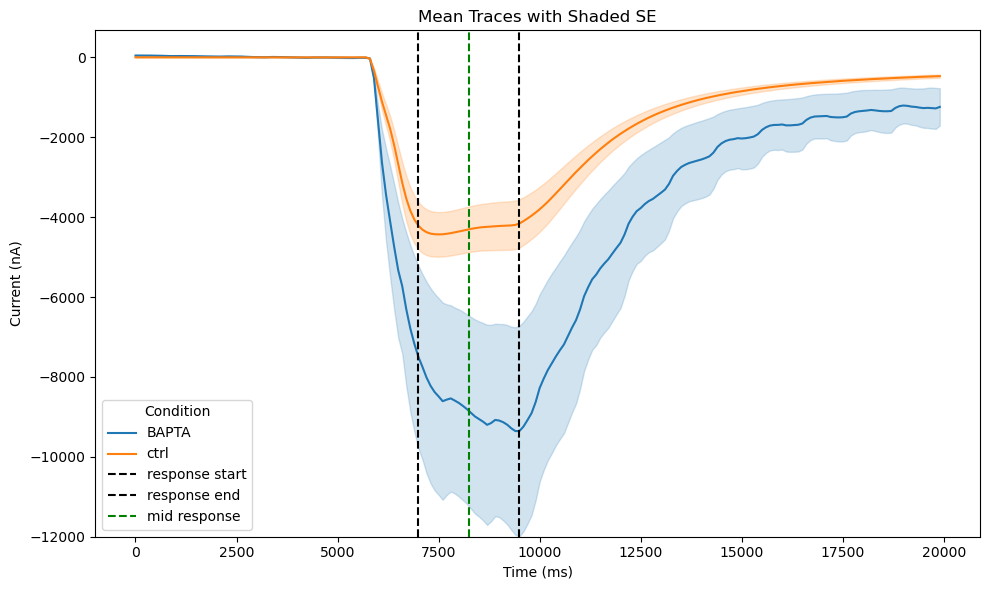

In [63]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=downsampled_filtered, x='Time (ms)', y='Response', hue='BAPTA_label', errorbar='se')
plt.title('Mean Traces with Shaded SE')
plt.ylabel('Current (nA)')
plt.xlabel('Time (ms)')
plt.ylim(-12000)

# Add vertical line at start of response
plt.axvline(x=t_response_start, color='black', linestyle='--', label='response start')
# Add vertical line at end of application
#plt.axvline(x=t_application_end, color='red', linestyle='--', label='application end')
# Add vertical line at end of response
plt.axvline(x=t_response_end, color='black', linestyle='--', label='response end')
# Add vertical line at middle of response
plt.axvline(x=t_mid_response, color='green', linestyle='--', label='mid response')

plt.legend(title='Condition')
plt.tight_layout()

#save pdf
output_filepath = output_folder / 'Mean_traces.pdf'
plt.savefig(output_filepath, format='pdf')
print(f'PDF files saved in the {output_folder} folder.')
plt.show()

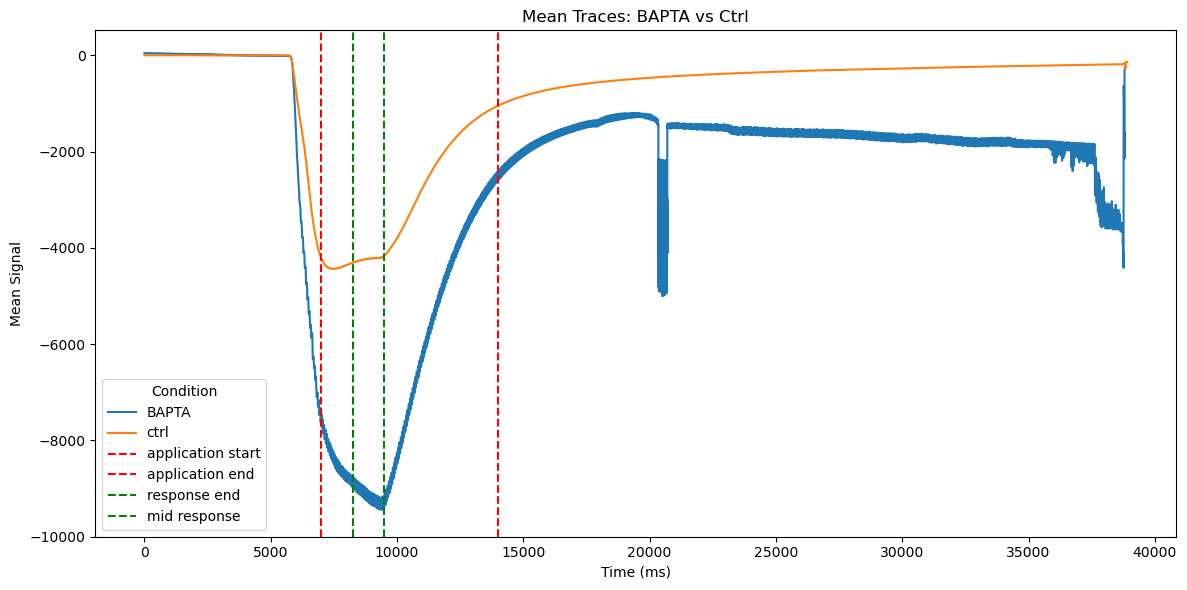

In [43]:
# Create mean traces for BAPTA and control
#NO FILTER and NO ERROR - runs much faster
mean_traces = merged_data.groupby('BAPTA_label').mean(numeric_only=True)
mean_traces = mean_traces.iloc[:, 4:]  # Drop first 4 non-timepoint cols

plt.figure(figsize=(12, 6))

# Plot each mean trace
for label in mean_traces.index:
    plt.plot(mean_traces.columns.astype(int), mean_traces.loc[label], label=label)

# Add vertical line at start of response
plt.axvline(x=t_response_start, color='red', linestyle='--', label='application start')
# Add vertical line at end of application
plt.axvline(x=t_application_end, color='red', linestyle='--', label='application end')
# Add vertical line at end of response
plt.axvline(x=t_response_end, color='green', linestyle='--', label='response end')
# Add vertical line at middle of response
plt.axvline(x=t_mid_response, color='green', linestyle='--', label='mid response')

plt.xlabel('Time (ms)')
plt.ylabel('Mean Signal')
plt.ylim(-10000)
plt.title('Mean Traces: BAPTA vs Ctrl')
plt.legend(title='Condition')
plt.tight_layout()
plt.show()

In [75]:
#CALCULATE MEAN IN FIRST AND SECOND PHASE OF RESPONSE PER TRACE

# Define the two time windows (in ms)
t_response_phase_1 = (t_response_start, t_mid_response)
t_response_phase_2 = (t_mid_response, t_response_end)

# Phase 1 mean per trace
phase1_means = (
    downsampled_filtered[
        (downsampled_filtered['Time (ms)'] >= t_response_phase_1[0]) &
        (downsampled_filtered['Time (ms)'] < t_response_phase_1[1])
    ]
    .groupby('unique_trace_ID')['Response']
    .mean()
    .rename('mean_phase_1')
)

# Phase 2 mean per trace
phase2_means = (
    downsampled_filtered[
        (downsampled_filtered['Time (ms)'] >= t_response_phase_2[0]) &
        (downsampled_filtered['Time (ms)'] < t_response_phase_2[1])
    ]
    .groupby('unique_trace_ID')['Response']
    .mean()
    .rename('mean_phase_2')
)

# Phase 1 min per trace
phase1_mins = (
    downsampled_filtered[
        (downsampled_filtered['Time (ms)'] >= t_response_phase_1[0]) &
        (downsampled_filtered['Time (ms)'] < t_response_phase_1[1])
    ]
    .groupby('unique_trace_ID')['Response']
    .min()
    .rename('min_phase_1')
)

# Phase 2 min per trace
phase2_mins = (
    downsampled_filtered[
        (downsampled_filtered['Time (ms)'] >= t_response_phase_2[0]) &
        (downsampled_filtered['Time (ms)'] < t_response_phase_2[1])
    ]
    .groupby('unique_trace_ID')['Response']
    .min()
    .rename('min_phase_2')
)

# Combine all into a single DataFrame
response_phases = pd.concat([phase1_means, phase2_means, phase1_mins, phase2_mins], axis=1).reset_index()

# Merge in condition labels (e.g., BAPTA vs ctrl)
trace_labels = downsampled_filtered[['unique_trace_ID', 'BAPTA_label']].drop_duplicates()
response_phases = response_phases.merge(trace_labels, on='unique_trace_ID')

# Compute ratios and diff
response_phases['mean_ratio'] = response_phases['mean_phase_1'] / response_phases['mean_phase_2']
response_phases['min_ratio'] = response_phases['min_phase_1'] / response_phases['min_phase_2']
response_phases['min_diff'] = response_phases['min_phase_1'] - response_phases['min_phase_2']

response_phases.head(5)

,unique_trace_ID,mean_phase_1,mean_phase_2,min_phase_1,min_phase_2,BAPTA_label,mean_ratio,min_ratio,min_diff
0,BAPTA_A10_TR_BAPTA_acr21+lgc4_29.04.25_Export_39,-9355.107692,-10171.150000,-9965.2,-10248.0,BAPTA,0.919769,0.972404,282.8
1,BAPTA_A1_TR_BAPTA_acr21+lgc4_29.04.25_Export_31,-1476.476923,-1795.525000,-1696.5,-1861.7,BAPTA,0.822309,0.911264,165.2
2,BAPTA_A1_TR_lgc-4.acr-21_01.05.25_Export_11,-1006.246154,-1176.616667,-1115.8,-1219.9,BAPTA,0.855203,0.914665,104.1
3,BAPTA_A2_TR_BAPTA_acr21+lgc4_29.04.25_Export_32,-5098.907692,-5484.500000,-5421.0,-5520.8,BAPTA,0.929694,0.981923,99.8
4,BAPTA_A2_TR_lgc-4.acr-21_01.05.25_Export_12,-1118.861538,-1270.483333,-1231.0,-1288.2,BAPTA,0.880658,0.955597,57.2


T-statistic: -5.6223
P-value: 1.1672e-06
Yes, significant difference (p < 0.05)
PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/acr21_lgc4/BAPTA/output_plots folder.


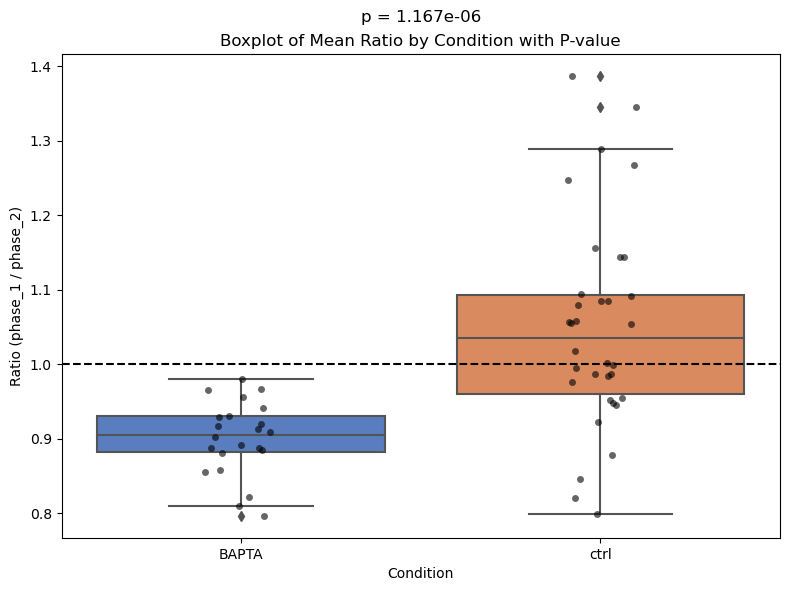

In [47]:
# Separate the mean_ratio values by group
group_bapta = response_phases[response_phases['BAPTA_label'] == 'BAPTA']['mean_ratio']
group_ctrl = response_phases[response_phases['BAPTA_label'] == 'ctrl']['mean_ratio']

# Run independent t-test (assumes unequal variances)
t_stat, p_value = ttest_ind(group_bapta, group_ctrl, equal_var=False)

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4e}")

if p_value < 0.05:
    print("Yes, significant difference (p < 0.05)")
else:
    print("No significant difference (p >= 0.05)")

plt.figure(figsize=(8,6))

# Boxplot
sns.boxplot(data=response_phases, x='BAPTA_label', y='mean_ratio', palette='muted')

# Overlay individual points (jittered)
sns.stripplot(data=response_phases, x='BAPTA_label', y='mean_ratio', color='black', jitter=True, alpha=0.6)

# Annotate p-value on plot
plt.text(0.5, response_phases['mean_ratio'].max() * 1.05, f'p = {p_value:.3e}', 
         ha='center', va='bottom', fontsize=12)

# Add line at 1
plt.axhline(y=1, color='black', linestyle='--')

plt.title('Boxplot of Mean Ratio by Condition with P-value')
plt.ylabel('Ratio (phase_1 / phase_2)')
plt.xlabel('Condition')
plt.tight_layout()

#save pdf
output_filepath = output_folder / 'Boxplot_Ratio.pdf'
plt.savefig(output_filepath, format='pdf')
print(f'PDF files saved in the {output_folder} folder.')
plt.show()

In [66]:
#TIME TO PEAK CURRENT AFTER ONSET --> SHOULD TELL YOU IF ITS POINTY OR NOT
#would be good if onset time was not fixed but worked out from the trace... but do more simple first

# Filter out rows where Time (ms) > 10000
filtered_df = downsampled_filtered[downsampled_filtered['Time (ms)'] <= 15000]

# Find index of minimum Response_filtered per unique_trace_ID minus start time
idx_min = filtered_df.groupby('unique_trace_ID')['Response_filtered'].idxmin()

# Extract the rows with min response per trace
min_response_times = filtered_df.loc[idx_min, ['BAPTA_label', 'unique_trace_ID', 'Time (ms)', 'Response_filtered']].reset_index(drop=True)
min_response_times['Time to Peak (ms)'] = min_response_times['Time (ms)'] - t_first_response
min_response_times.head()

,BAPTA_label,unique_trace_ID,Time (ms),Response_filtered,Time to Peak (ms)
0,BAPTA,BAPTA_A10_TR_BAPTA_acr21+lgc4_29.04.25_Export_39,9300,-10256.186489,3500
1,BAPTA,BAPTA_A1_TR_BAPTA_acr21+lgc4_29.04.25_Export_31,9400,-1852.028435,3600
2,BAPTA,BAPTA_A1_TR_lgc-4.acr-21_01.05.25_Export_11,9400,-1219.043047,3600
3,BAPTA,BAPTA_A2_TR_BAPTA_acr21+lgc4_29.04.25_Export_32,9300,-5504.135005,3500
4,BAPTA,BAPTA_A2_TR_lgc-4.acr-21_01.05.25_Export_12,9300,-1288.130891,3500


T-statistic: 7.7067
P-value: 1.3895e-09
Yes, significant difference (p < 0.05)
PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/acr21_lgc4/BAPTA/output_plots folder.


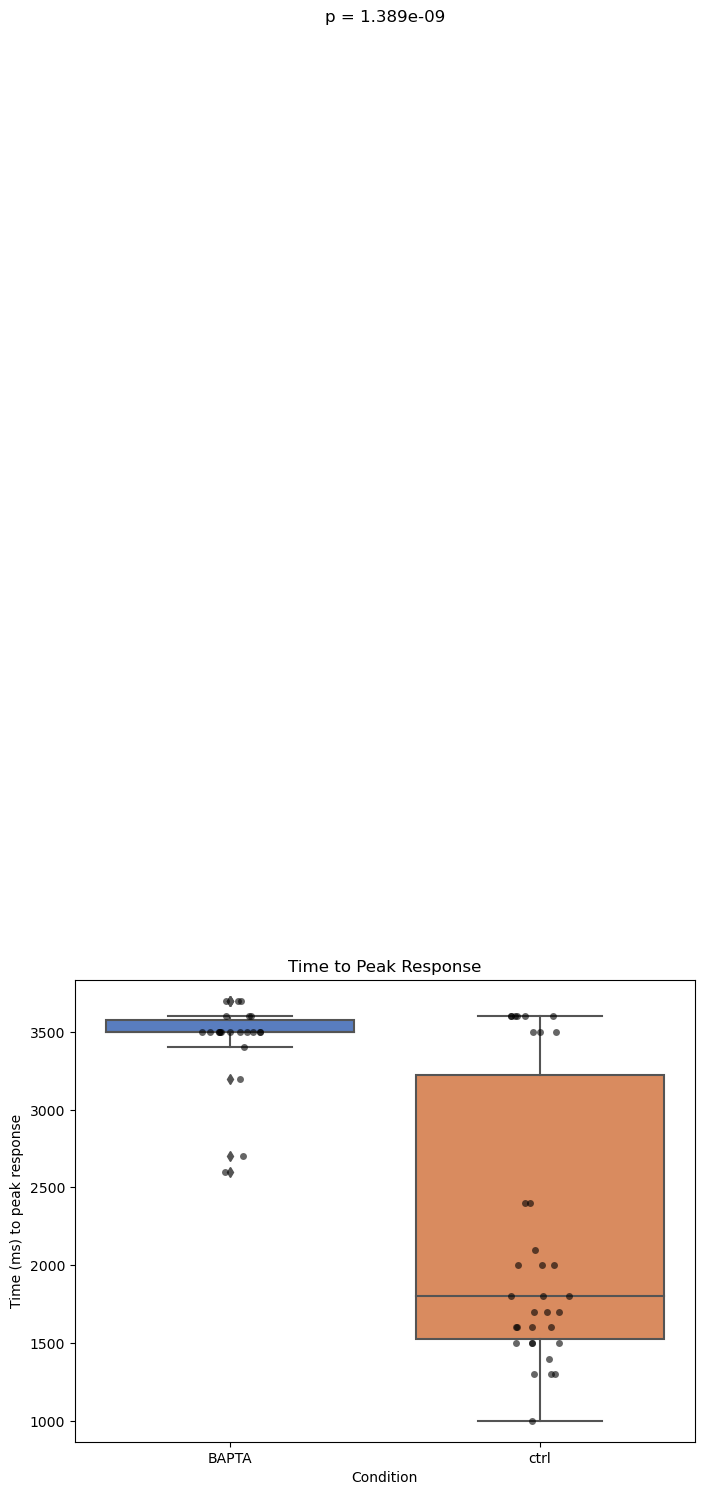

In [ ]:
# Separate the mean_ratio values by group
group_bapta = min_response_times[min_response_times['BAPTA_label'] == 'BAPTA']['Time to Peak (ms)']
group_ctrl = min_response_times[min_response_times['BAPTA_label'] == 'ctrl']['Time to Peak (ms)']

# Run independent t-test (assumes unequal variances)
t_stat, p_value = ttest_ind(group_bapta, group_ctrl, equal_var=False)

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4e}")

if p_value < 0.05:
    print("Yes, significant difference (p < 0.05)")
else:
    print("No significant difference (p >= 0.05)")

plt.figure(figsize=(8,6))

sns.boxplot(data=min_response_times, x='BAPTA_label', y='Time to Peak (ms)', palette='muted')
sns.stripplot(data=min_response_times, x='BAPTA_label', y='Time to Peak (ms)', color='black', jitter=True, alpha=0.6)

plt.title('Time to Peak Response')
plt.ylabel('Time (ms) to peak response')
plt.xlabel('Condition')

plt.text(
    0.5, 
    min_response_times['Time (ms)'].max() * 1.05, 
    f'p = {p_value:.3e}', 
    ha='center', 
    va='bottom', 
    fontsize=12
)

plt.tight_layout()

#save pdf
output_filepath = output_folder / 'Time_to_peak.pdf'
plt.savefig(output_filepath, format='pdf')
print(f'PDF files saved in the {output_folder} folder.')
plt.show()

In [71]:
#EXPORT DATA
min_response_times.to_csv(output_folder / 'min_response_times.csv')
response_phases.to_csv(output_folder / 'repsonse_phases.csv')


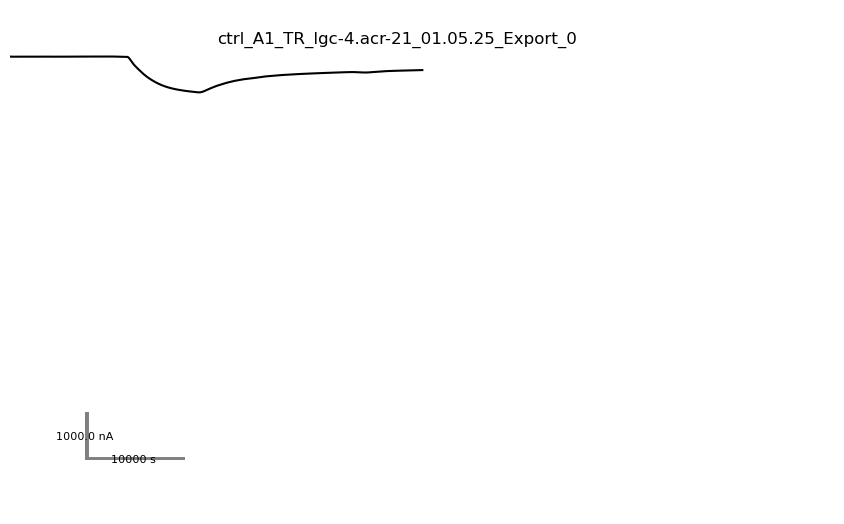

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/BAPTA/output_plots folder.


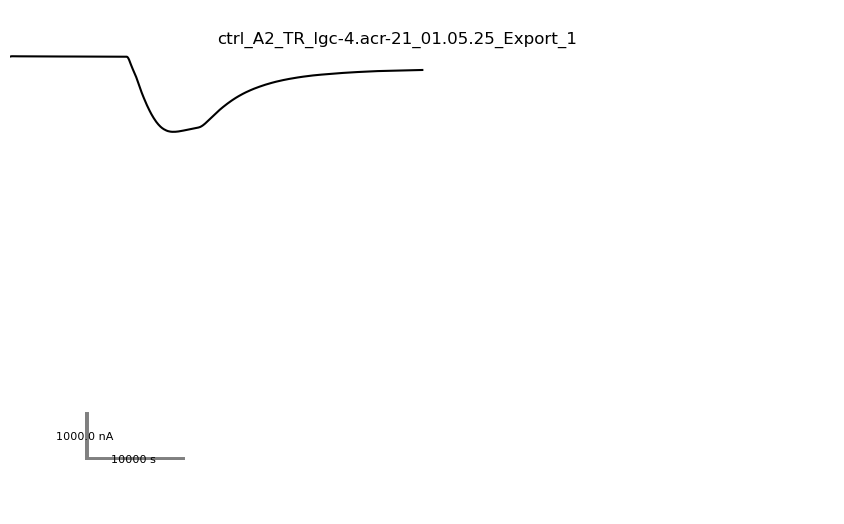

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/BAPTA/output_plots folder.


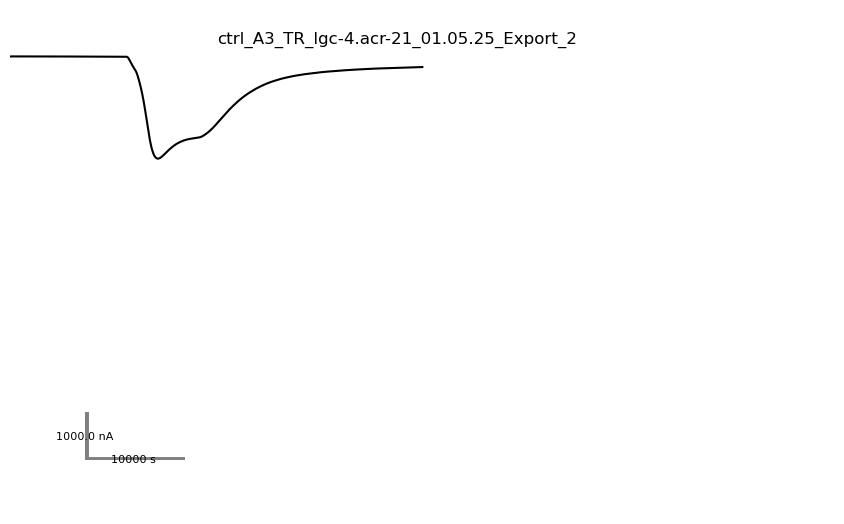

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/BAPTA/output_plots folder.


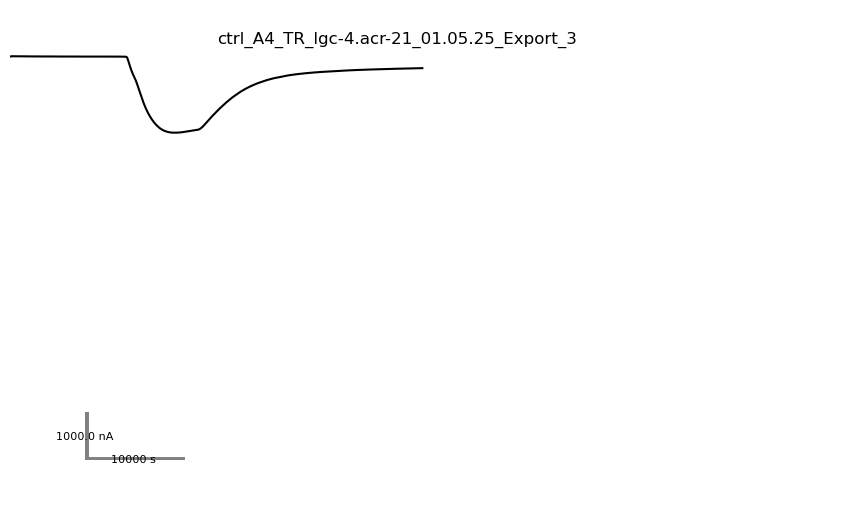

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/BAPTA/output_plots folder.


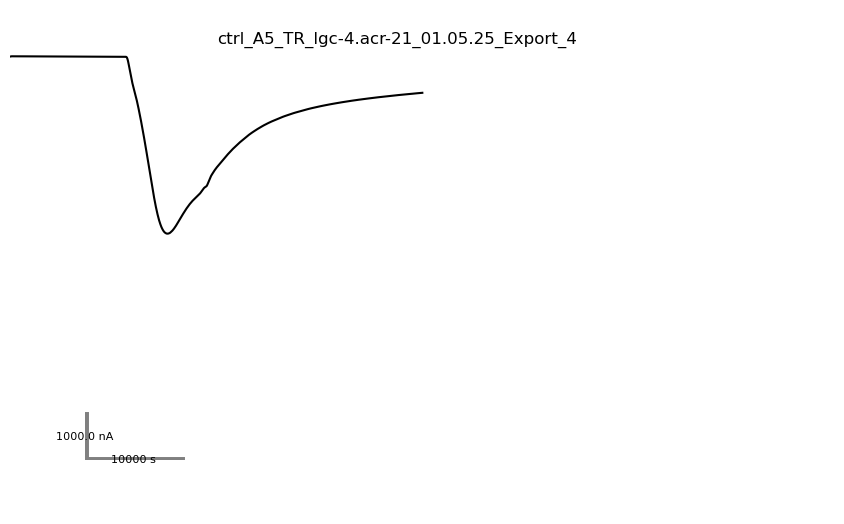

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/BAPTA/output_plots folder.


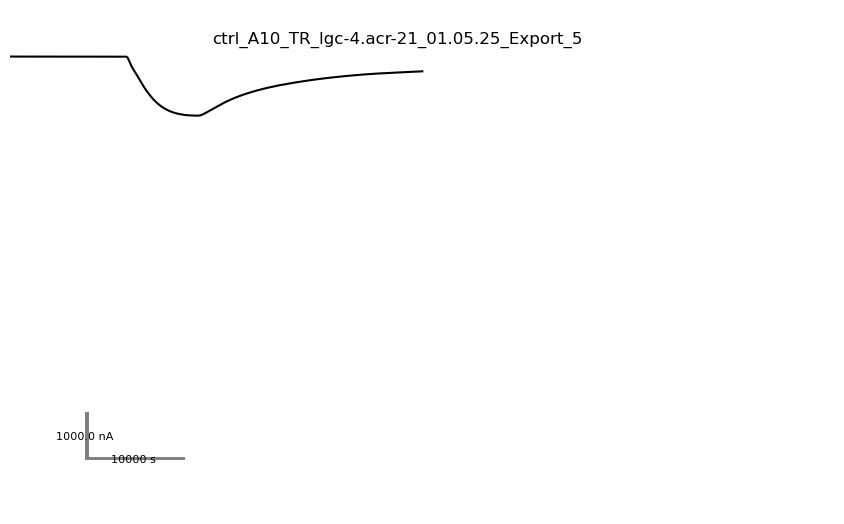

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/BAPTA/output_plots folder.


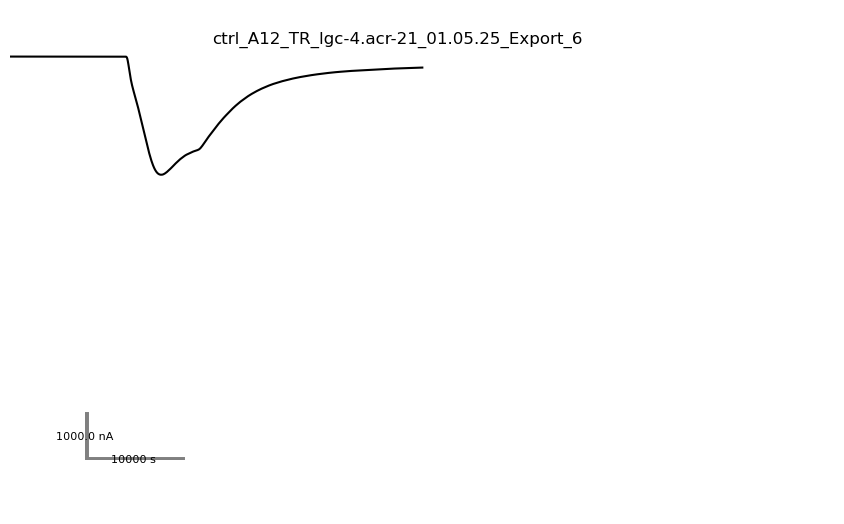

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/BAPTA/output_plots folder.


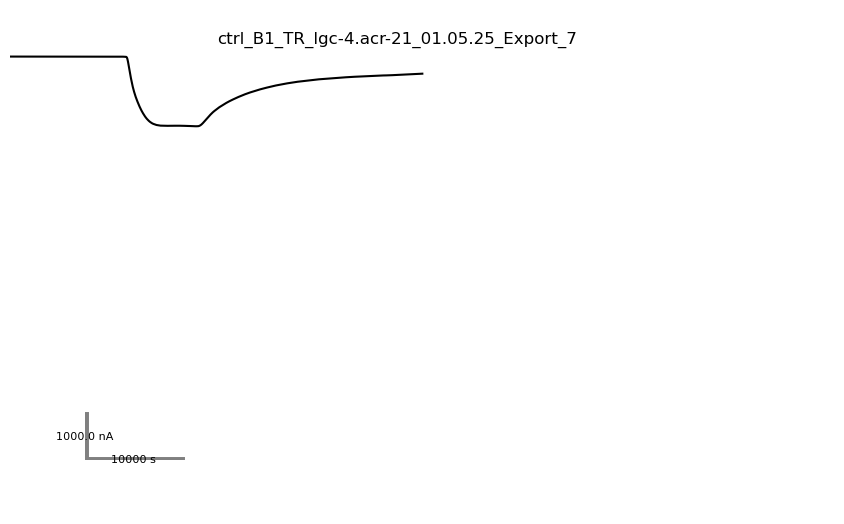

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/BAPTA/output_plots folder.


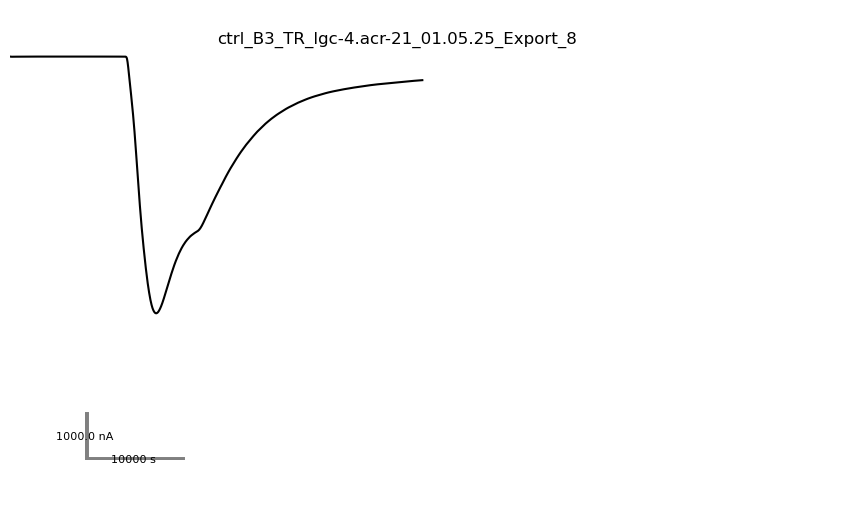

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/BAPTA/output_plots folder.


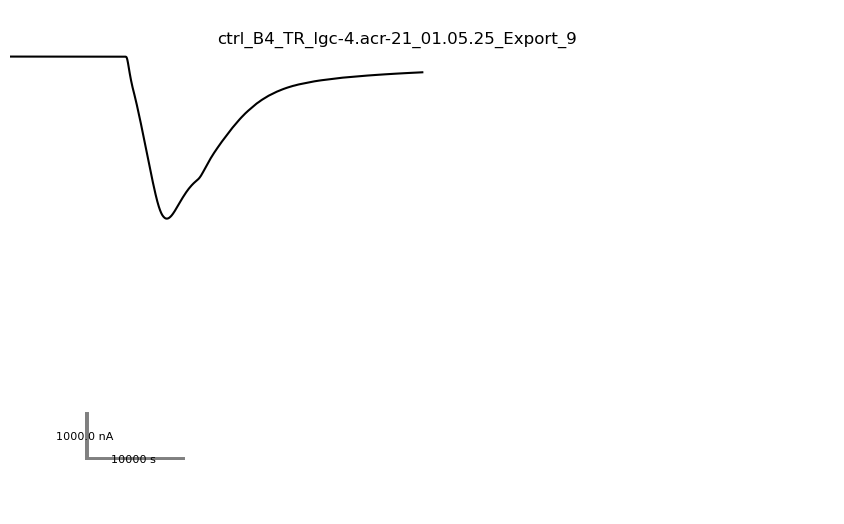

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/BAPTA/output_plots folder.


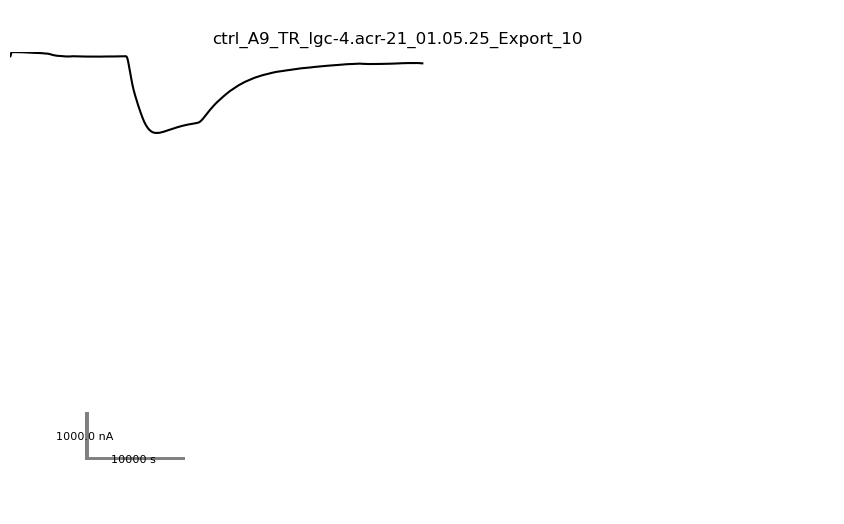

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/BAPTA/output_plots folder.


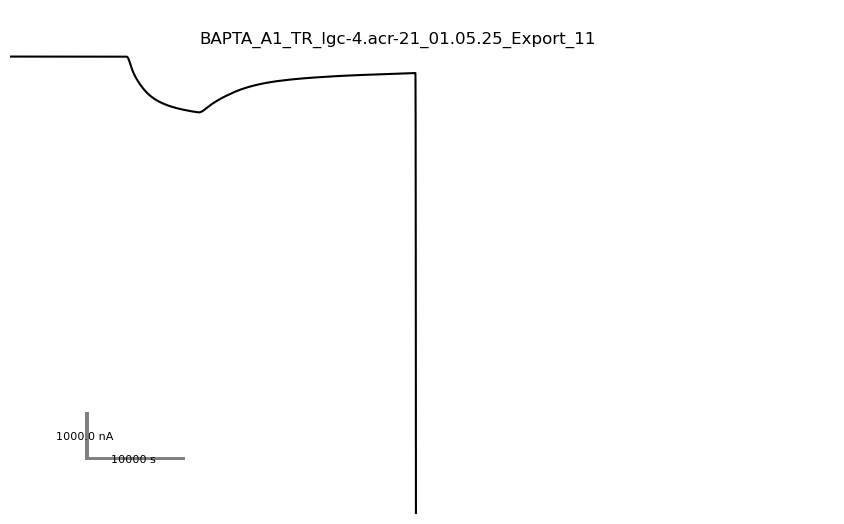

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/BAPTA/output_plots folder.


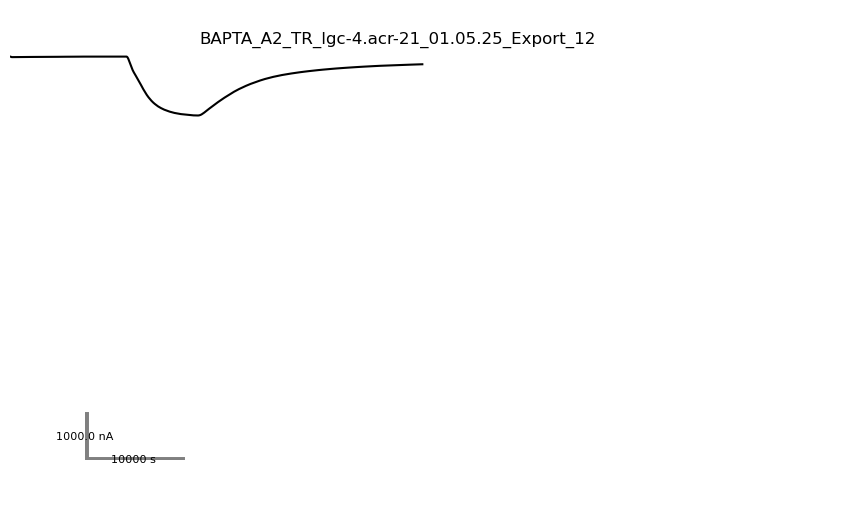

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/BAPTA/output_plots folder.


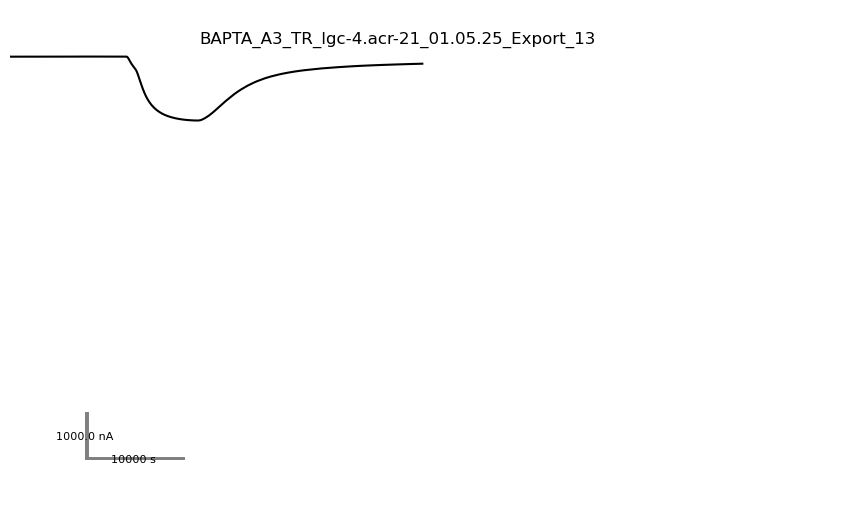

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/BAPTA/output_plots folder.


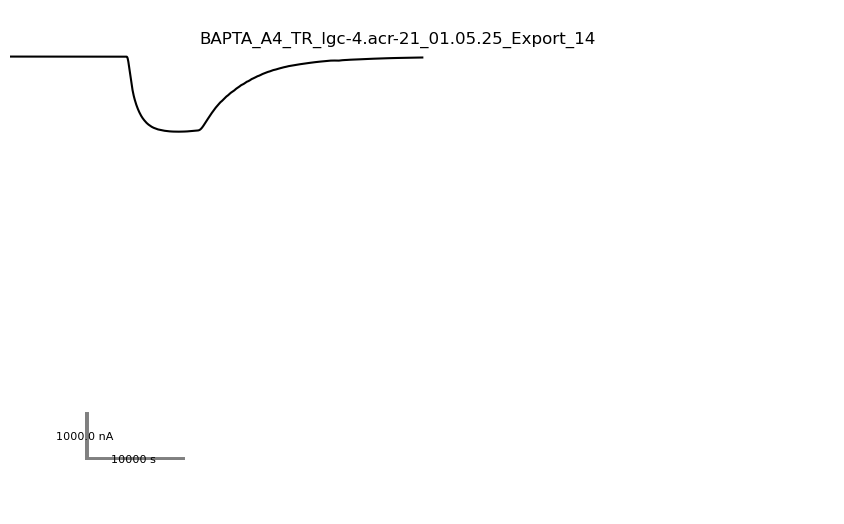

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/BAPTA/output_plots folder.


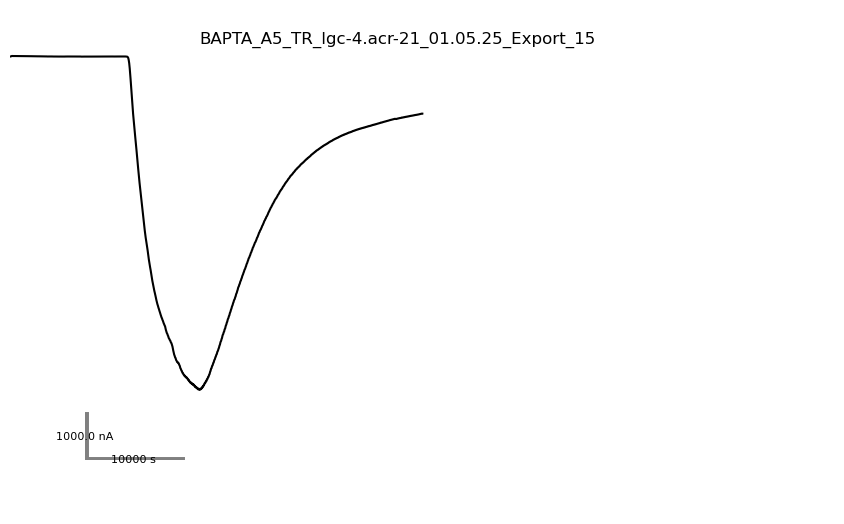

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/BAPTA/output_plots folder.


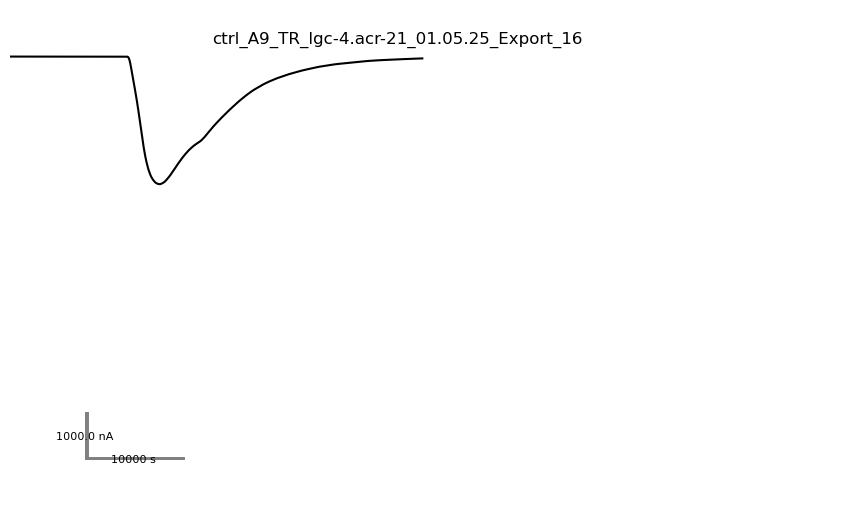

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/BAPTA/output_plots folder.


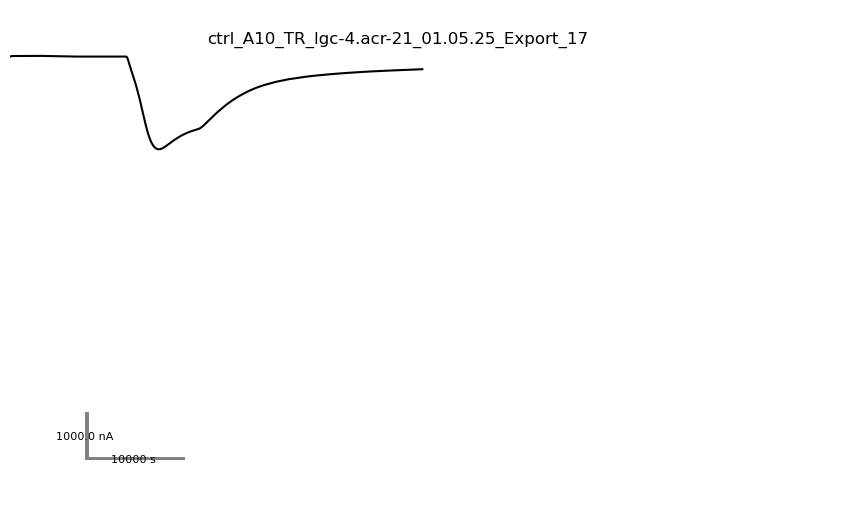

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/BAPTA/output_plots folder.


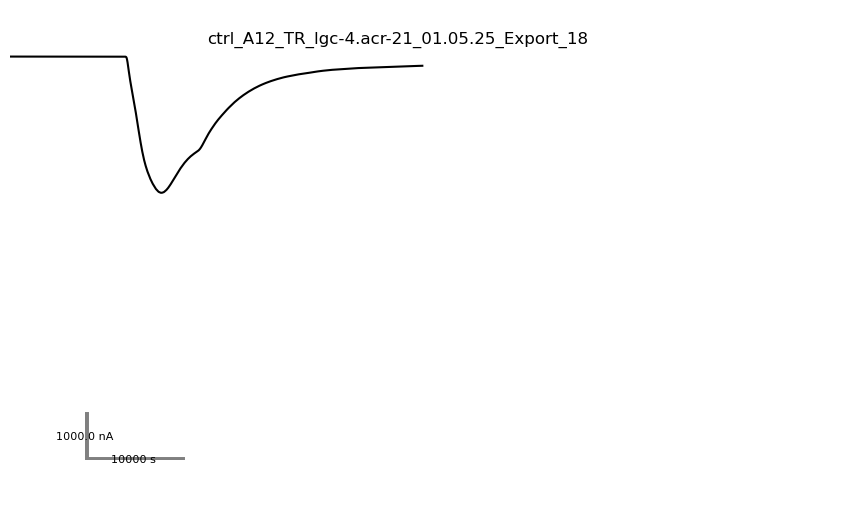

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/BAPTA/output_plots folder.


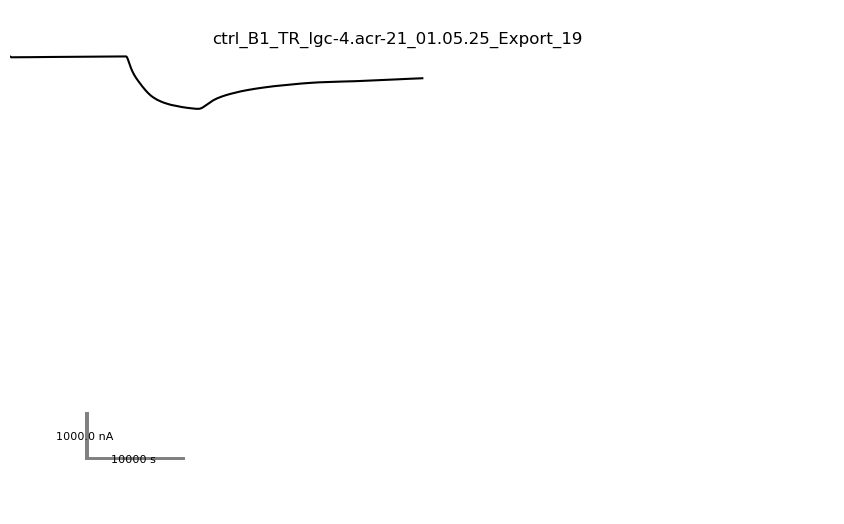

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/BAPTA/output_plots folder.


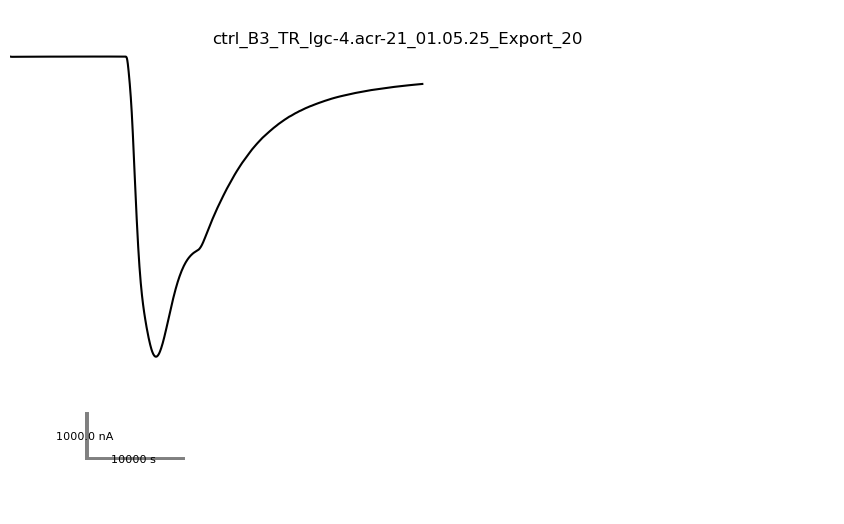

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/BAPTA/output_plots folder.


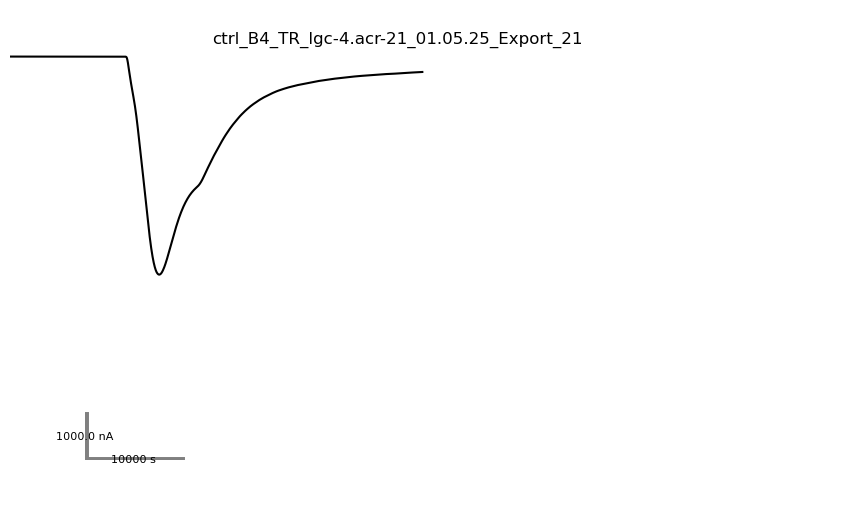

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/BAPTA/output_plots folder.


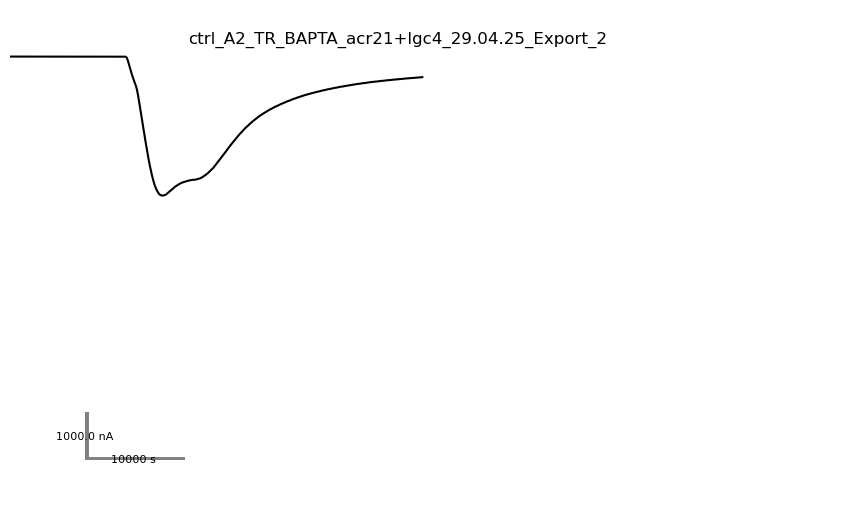

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/BAPTA/output_plots folder.


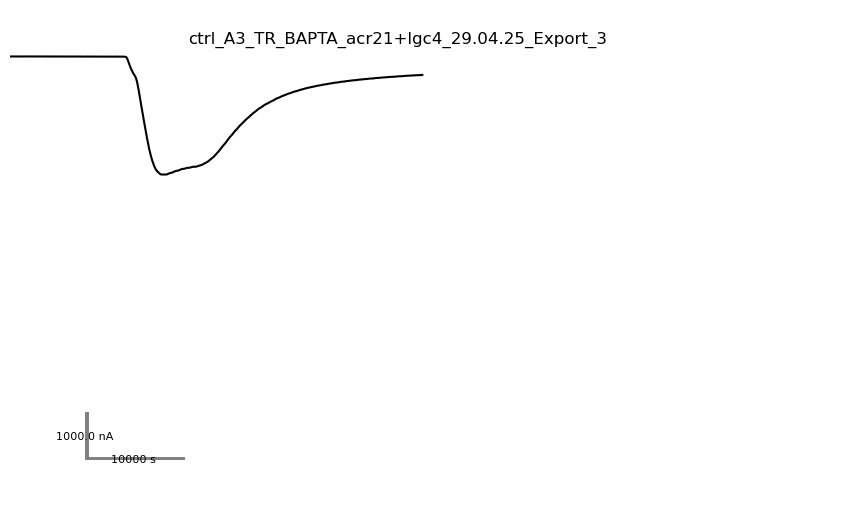

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/BAPTA/output_plots folder.


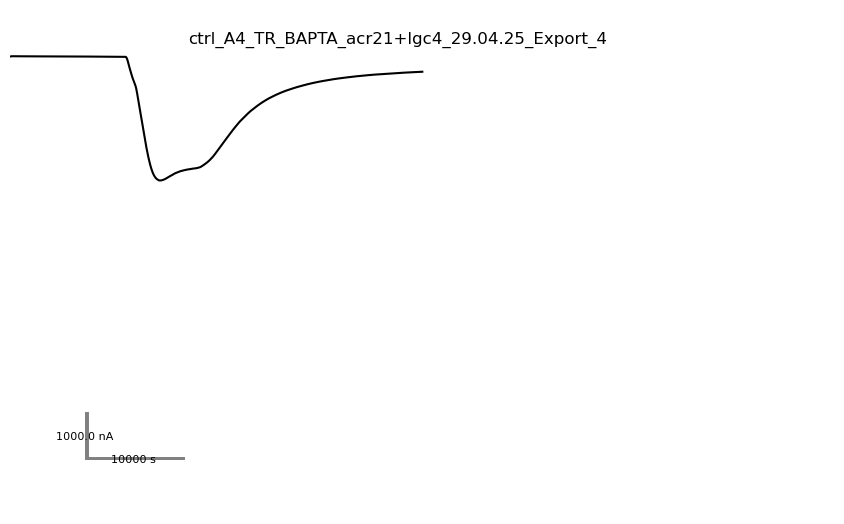

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/BAPTA/output_plots folder.


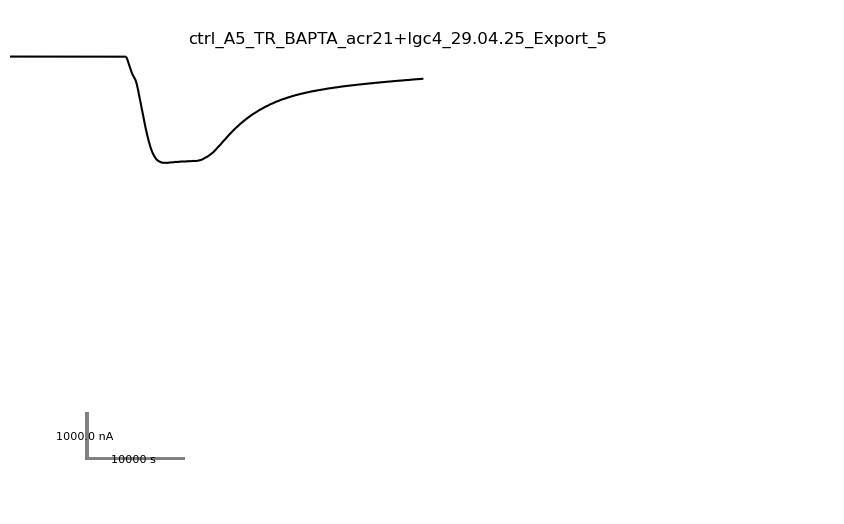

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/BAPTA/output_plots folder.


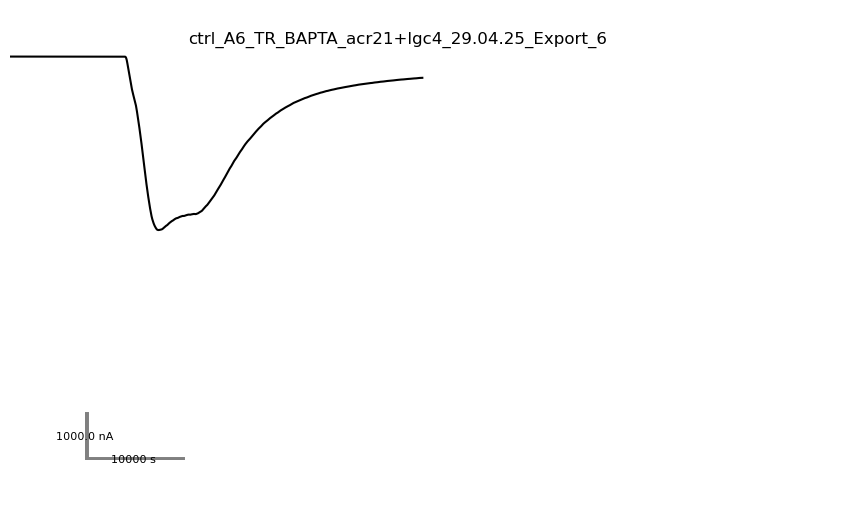

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/BAPTA/output_plots folder.


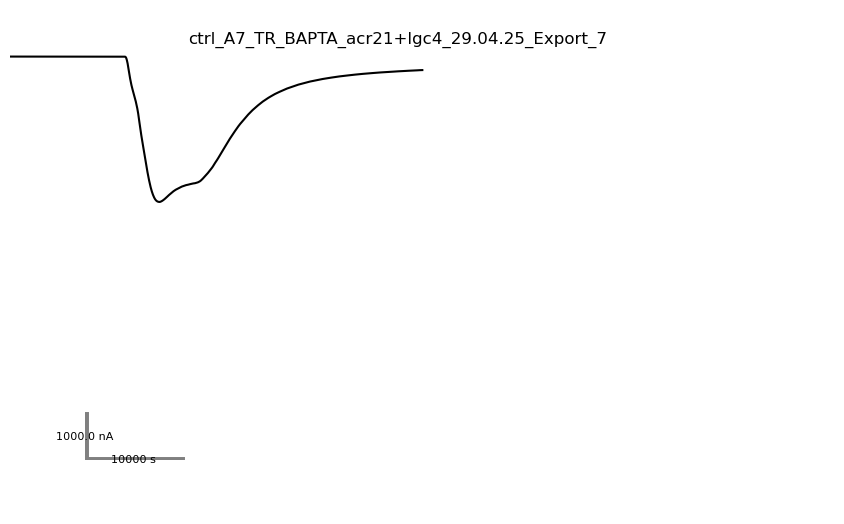

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/BAPTA/output_plots folder.


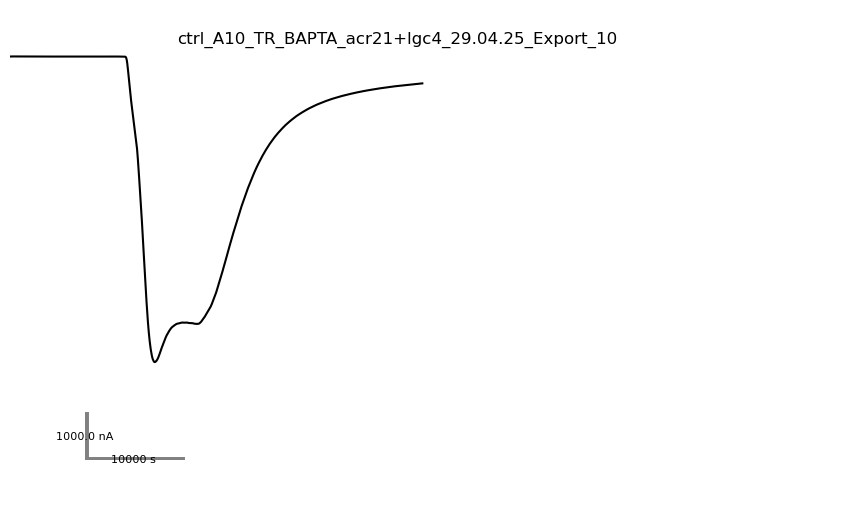

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/BAPTA/output_plots folder.


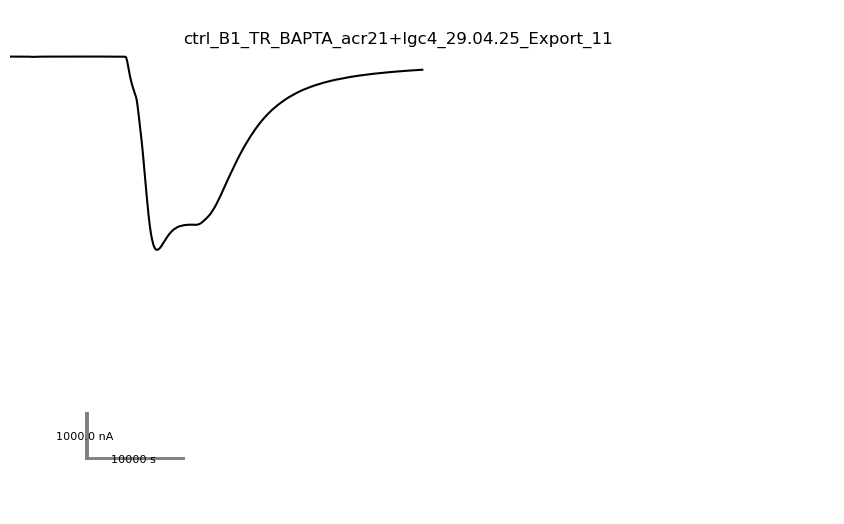

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/BAPTA/output_plots folder.


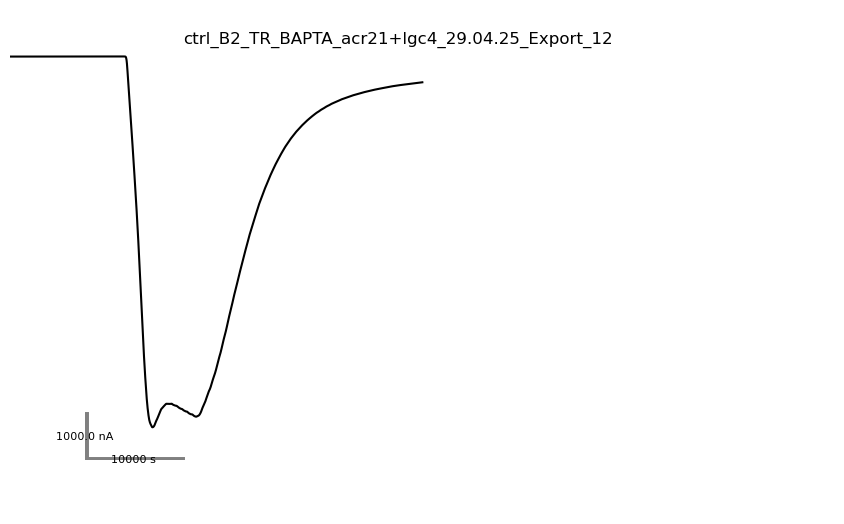

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/BAPTA/output_plots folder.


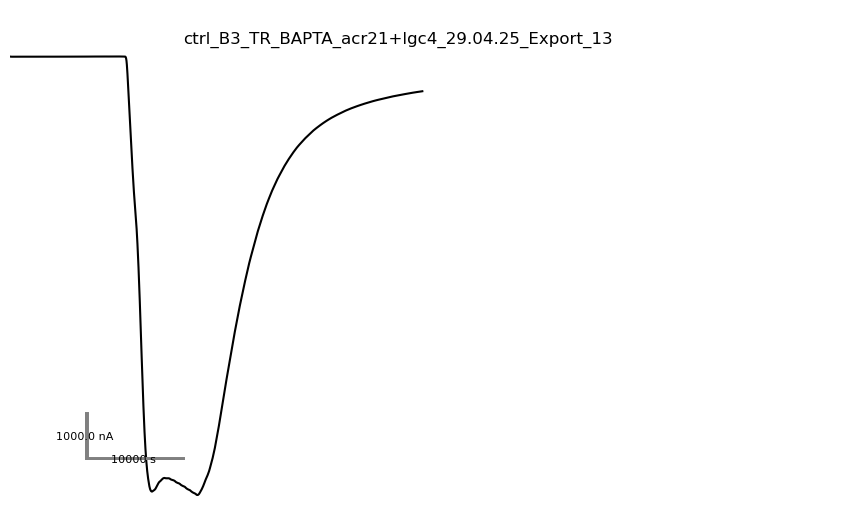

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/BAPTA/output_plots folder.


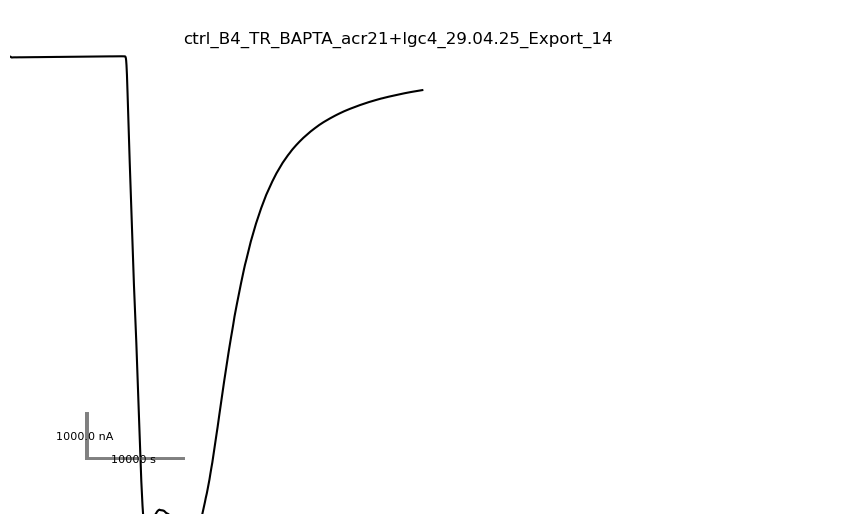

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/BAPTA/output_plots folder.


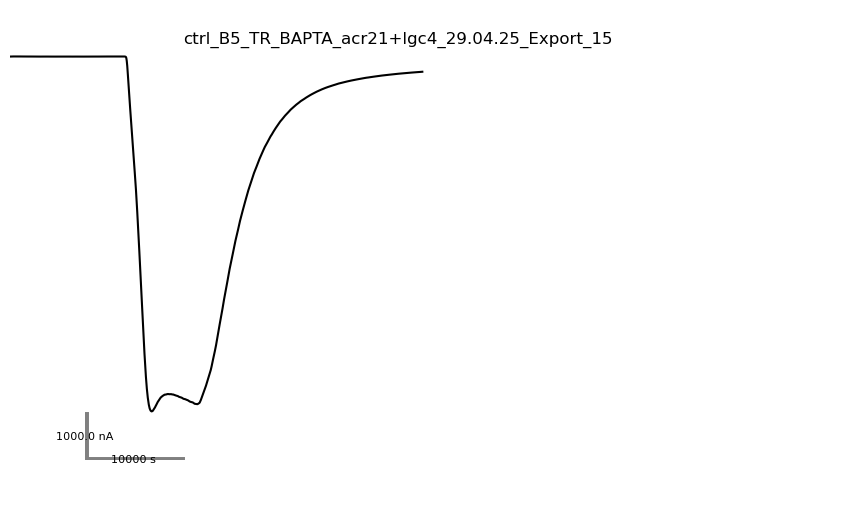

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/BAPTA/output_plots folder.


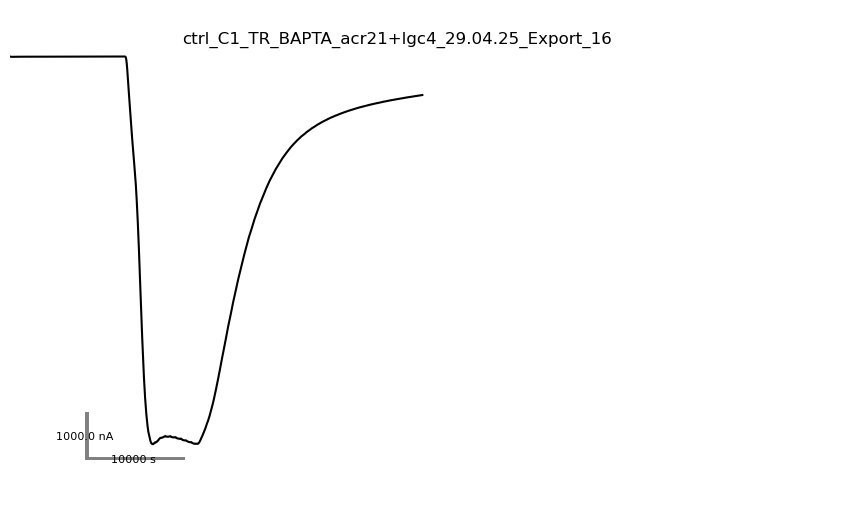

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/BAPTA/output_plots folder.


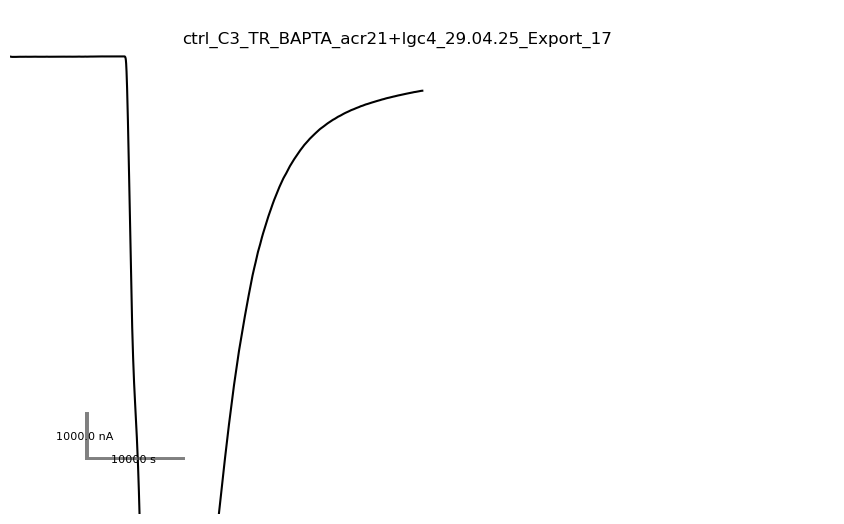

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/BAPTA/output_plots folder.


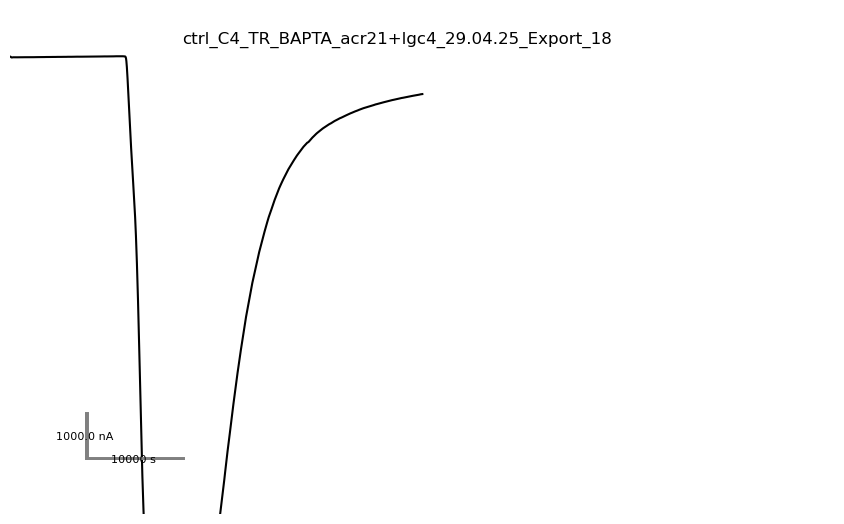

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/BAPTA/output_plots folder.


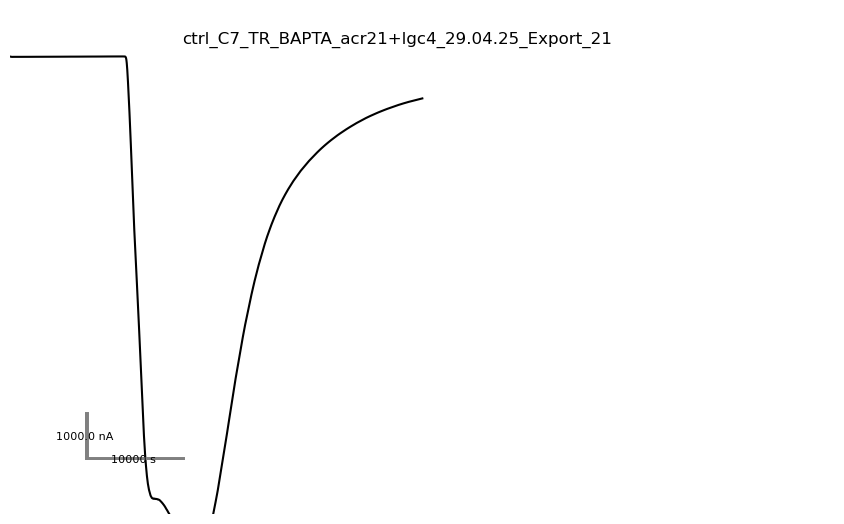

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/BAPTA/output_plots folder.


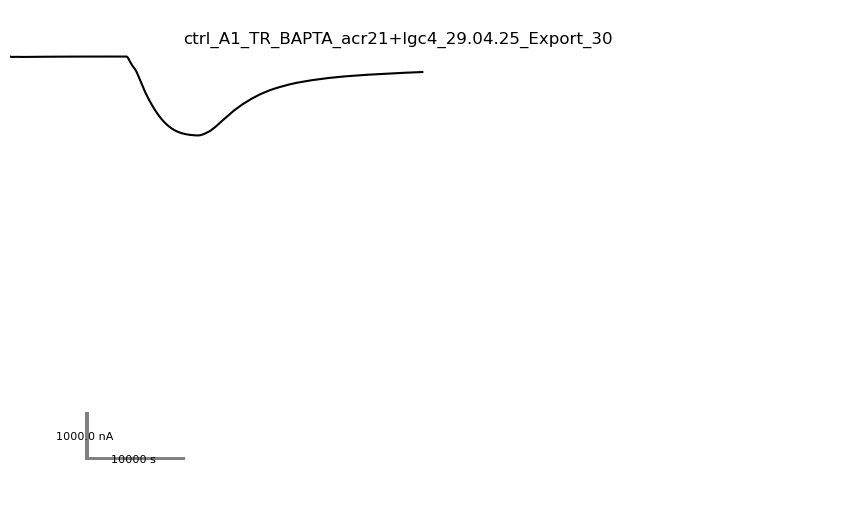

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/BAPTA/output_plots folder.


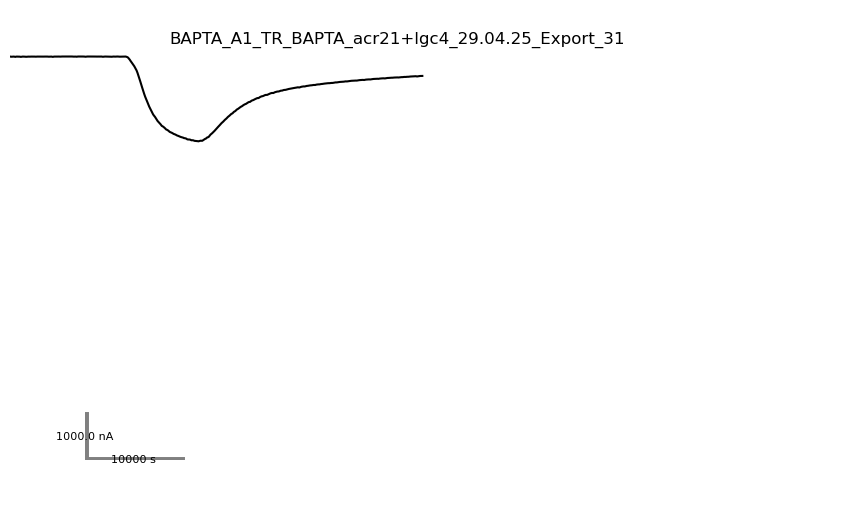

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/BAPTA/output_plots folder.


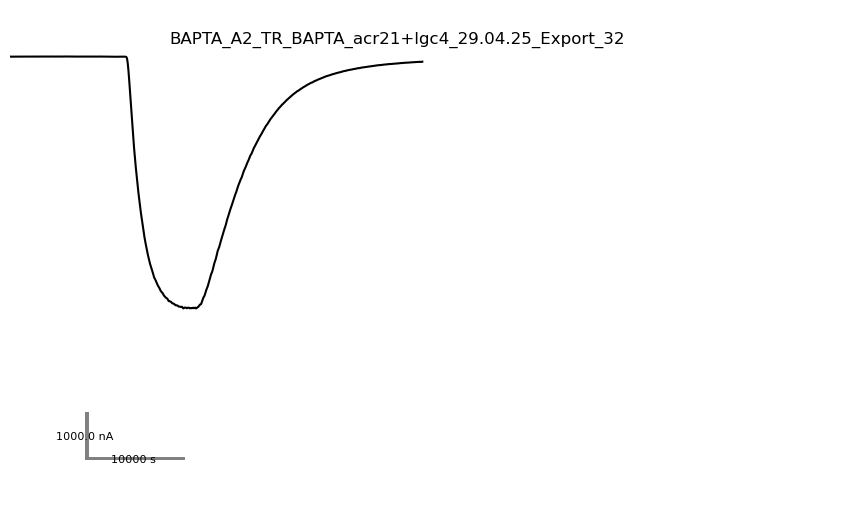

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/BAPTA/output_plots folder.


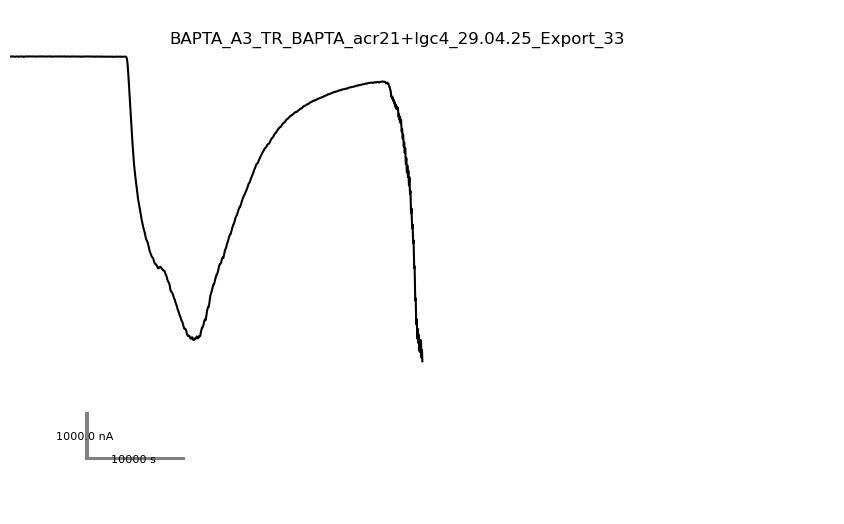

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/BAPTA/output_plots folder.


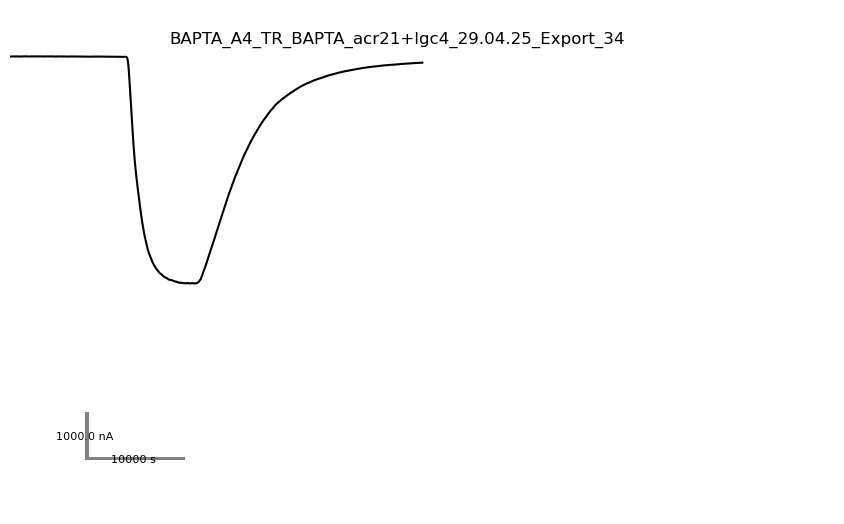

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/BAPTA/output_plots folder.


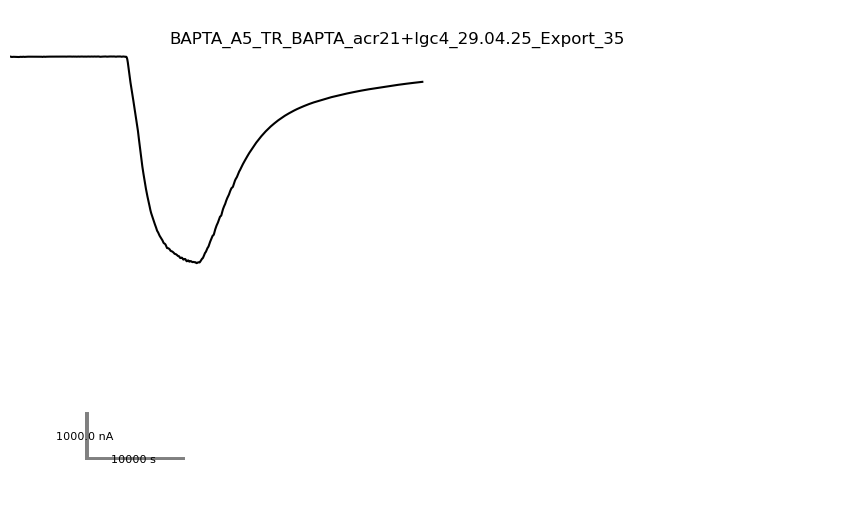

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/BAPTA/output_plots folder.


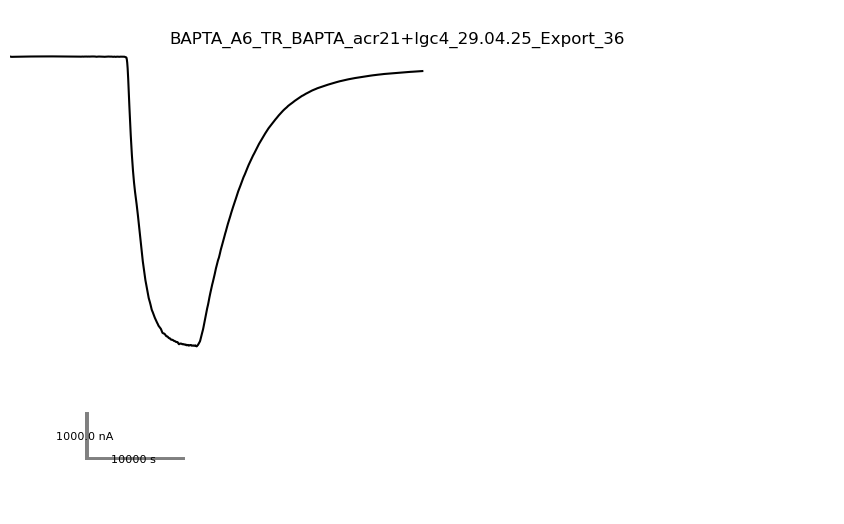

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/BAPTA/output_plots folder.


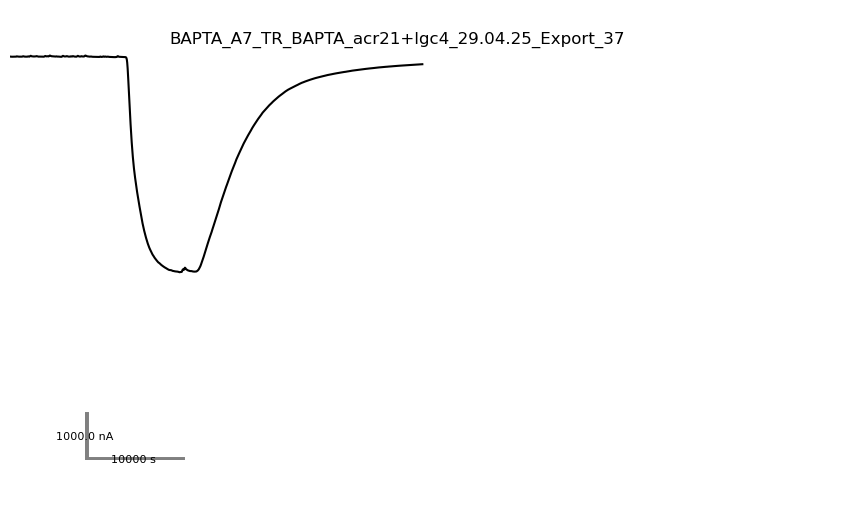

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/BAPTA/output_plots folder.


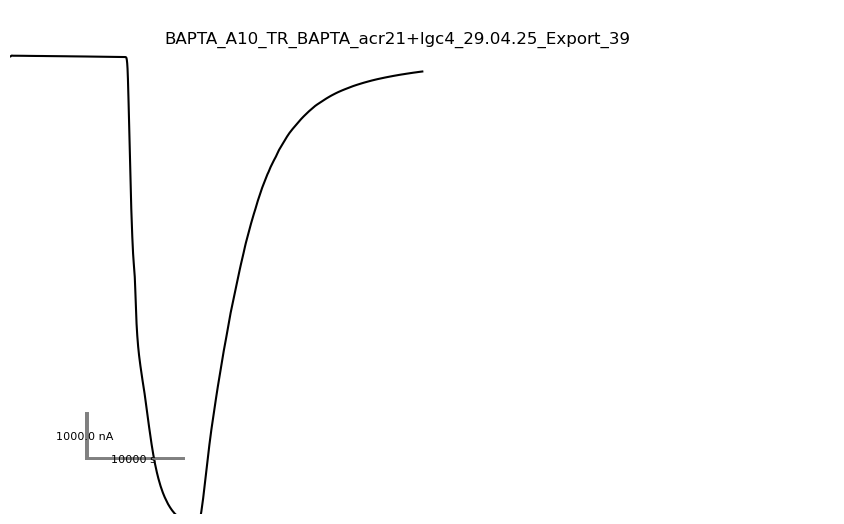

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/BAPTA/output_plots folder.


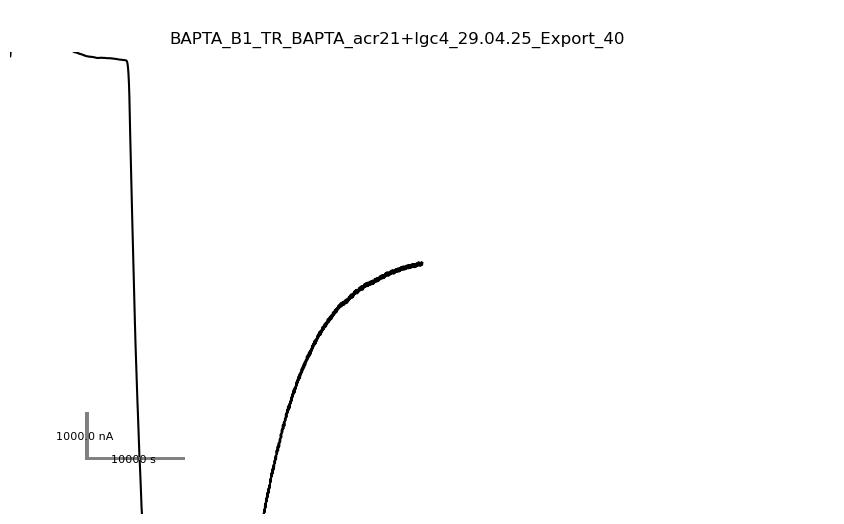

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/BAPTA/output_plots folder.


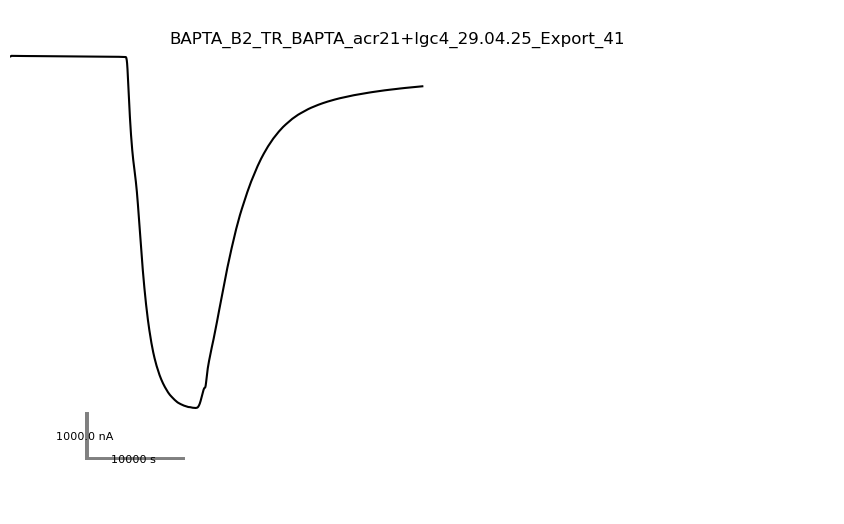

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/BAPTA/output_plots folder.


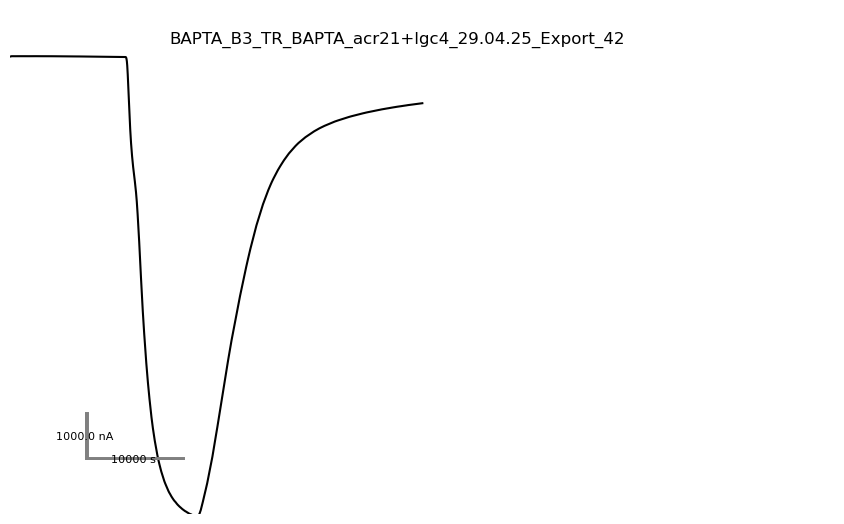

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/BAPTA/output_plots folder.


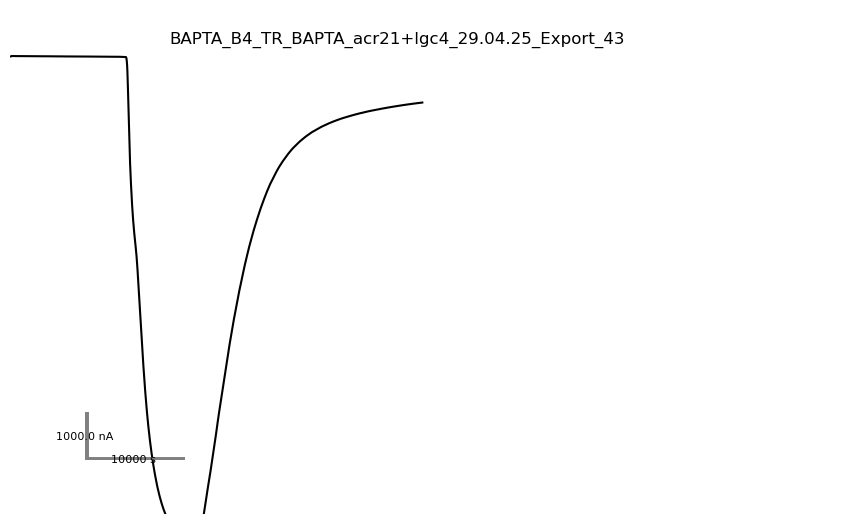

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/BAPTA/output_plots folder.


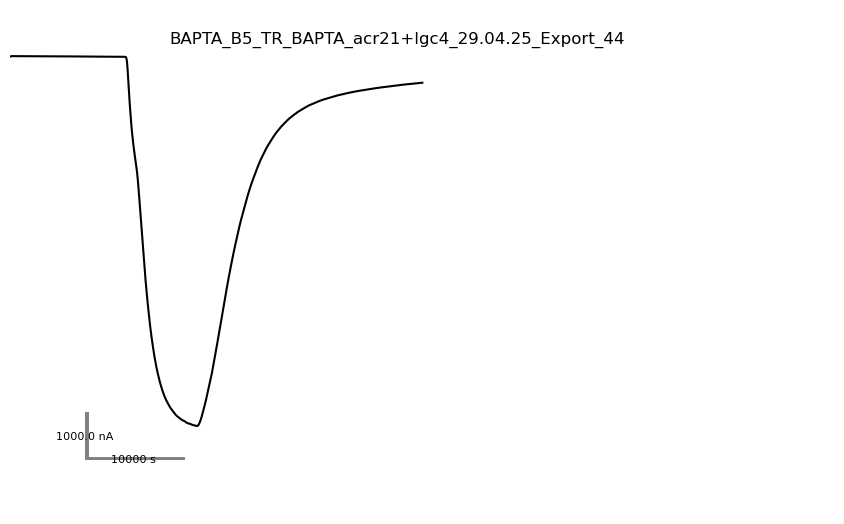

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/BAPTA/output_plots folder.


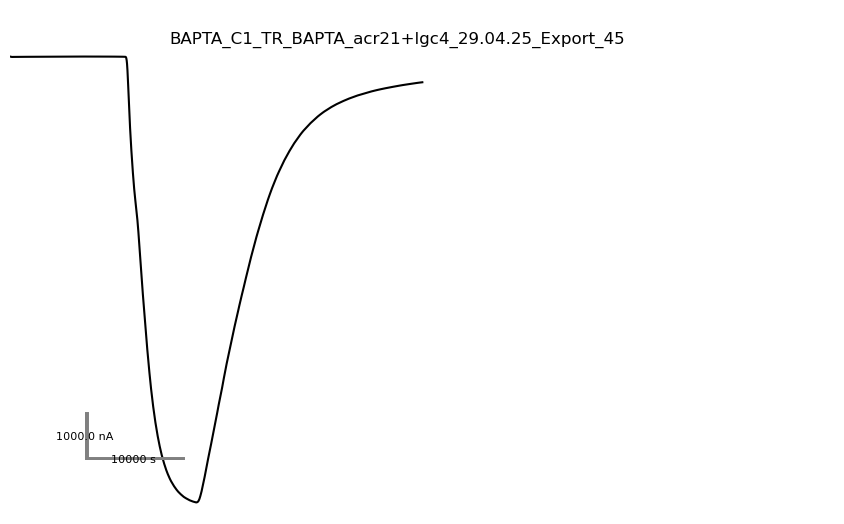

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/BAPTA/output_plots folder.


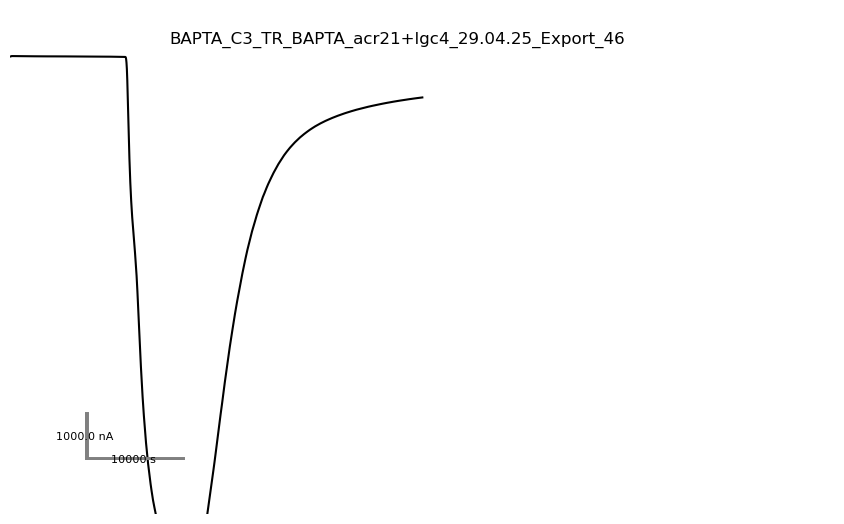

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/BAPTA/output_plots folder.


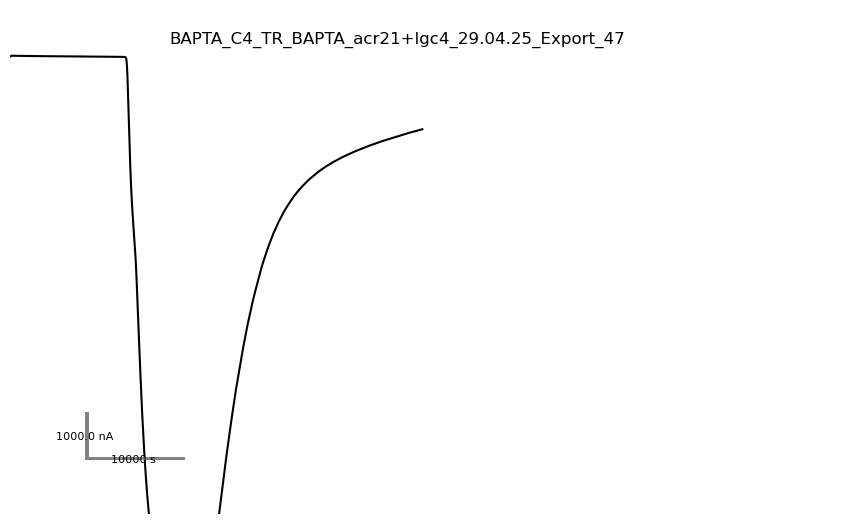

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/BAPTA/output_plots folder.


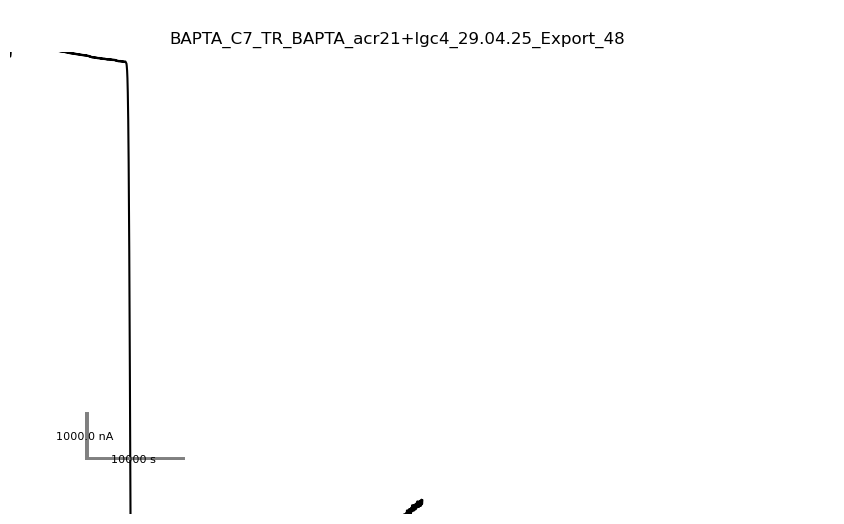

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/BAPTA/output_plots folder.


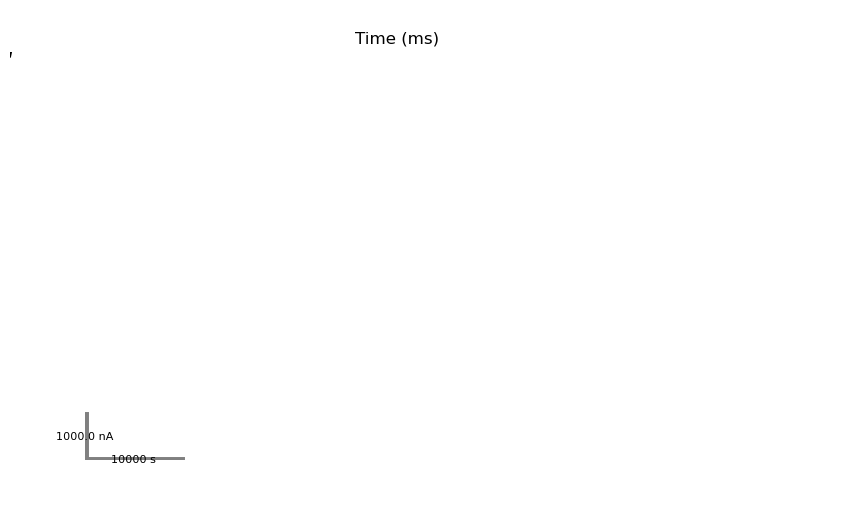

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/BAPTA/output_plots folder.


In [228]:
# EXPORT INDIVIDUAL PLOTS
#SELECT DATA
df = merged_data_filtered
df = df.apply(pd.to_numeric, errors='coerce')

# SAVE PLOTS?
save = True  # Change to False if you don't want to save the plots
# Define scale
maxy = - df.min(numeric_only=True, skipna=True).min(skipna=True) #find smallest value in df
maxy = 10000 #if you want defined y
maxx = len(df) *2
scale_bar_length = 10*1000 #seconds
scale_bar_height = maxy / 10 #n amps
# Calculate the position and size of the scale bar

# Directory to save PDF files
path2 = Path(path)  # use your path
output_folder = path2 / 'output_plots'

# Create the output folder if it doesn't exist
output_folder.mkdir(parents=True, exist_ok=True)

# Define a function to check if a value is numeric
def is_numeric(value):
    try:
        float(value)
        return True
    except ValueError:
        return False

# Apply pd.to_numeric with a custom function to filter non-numeric values for the whole DataFrame
df = df.apply(lambda x: pd.to_numeric(x, errors='coerce').where(x.apply(is_numeric)))

# Drop rows with any NaN values
df = df.dropna()

df['Time (ms)'] = pd.to_numeric(df.index, errors='coerce') *2

# Create a copy of the DataFrame for plotting
df_plot = df.copy()

# Plot each column in a separate figure
for col in df_plot.columns:
    fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the width and height as needed
    fig.set_size_inches(10, 6)
    ax.plot(df['Time (ms)'], df_plot[col], label=col, color='black')
    ax.set_ylim(-maxy, 100)
    ax.set_xlim(0, maxx)
    # Remove top and right axes lines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('nA')
    ax.set_title(col)
    # Create a mini-axes as a scale bar
    scale_bar_axes = fig.add_axes([0.2, 0.2, .75, .75])  # Adjust position and size as needed
    scale_bar_axes.plot([0, scale_bar_length], [0, 0], color='grey', linewidth=5)
    scale_bar_axes.plot([0, 0], [0, scale_bar_height], color='grey', linewidth=5)
    scale_bar_axes.set_xlim(0, maxx)
    scale_bar_axes.set_ylim(0, maxy)
    scale_bar_axes.axis('off')
    # Add text to the scale bar
    text_x_position = (scale_bar_length / 2)  # Center the text
    text_y_position = -2  # Adjust the vertical position
    text2_y_position = (scale_bar_height / 2)  # Center the text
    text2_x_position = -1  # Adjust the vertical position
    scale_bar_axes.text(text_x_position, text_y_position, f'{scale_bar_length} s', color='black', ha='center', va='center', fontsize=8)
    scale_bar_axes.text(text2_x_position, text2_y_position, f'{scale_bar_height} nA', color='black', ha='center', va='center', fontsize=8)

    if save:
        # Save the plot as a PDF in the output folder
        output_filepath = output_folder / f'{col}.pdf'
        plt.savefig(output_filepath, format='pdf')
        plt.show()
        plt.close()  # Close the current figure to release resources
        print(f'PDF files saved in the {output_folder} folder.')
    else:
        # If save is False, just display the plots without saving
        plt.show()
